## 0. Introduction

This file covers all parts related to the initial data explorations that are part of our defined research questions. The purpose of that is to dig deeper into data distributions and querying subtleties of the cleaned datasets. Subsequent in-depth analysis will follow in Milestone 3. The following parts are pre-requisites of this exploration and were done separately:

1. Dataset transformation and cleaning:

- Extraction of historical events from Wikipedia Timelines (`scripts/extract_wikipedia_timelines.ipynb`) 
- IMDb dataset extraction and merging with the main CMU movies dataset (`scripts/merge_imdb_with_cmu.ipynb`)
- Merging CMU movies with their summaries (`scripts/merge_movies_with_summaries.ipynb`)

2. Utility methods and functions to fetch structured Google Search Trends data:

- Functions to analyze movie genres and their distributions (`utils/genres.py`)
- Methods to fetch Google Trends data for given timelines and keywords (`utils/google_trends.py`)

In [1]:
import pandas as pd
import plotly.express as px
from collections import Counter
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.genres import *
from src.utils.genres import name_plot, count_genre_over_years, top_years_for_genre, bottom_years_for_genre, count_genres_by_year, calc_genre_differences, calc_genre_growth, calc_proportion_growth
import warnings
import csv
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk
from nltk.sentiment import SentimentIntensityAnalyzer
from src.utils import google_trends as gt
from data.Cleaning import final_df
warnings.simplefilter("ignore")
from ast import literal_eval
import plotly.graph_objects as go 

               WarName       StateName  Side  StartYear  EndYear  Outcome  \
0   Franco-Spanish War           Spain     2       1823     1823        2   
1   Franco-Spanish War          France     1       1823     1823        1   
2  First Russo-Turkish  Ottoman Empire     2       1828     1829        2   
3  First Russo-Turkish          Russia     1       1828     1829        1   
4     Mexican-American          Mexico     2       1846     1847        2   

   BatDeath  
0       600  
1       400  
2     80000  
3     50000  
4      6000  
Index(['WarName', 'Side', 'StartYear', 'EndYear', 'StateName', 'BatDeath'], dtype='object')
            WarName Side  StartYear  EndYear  \
2      Arab-Israeli    1       1948     1948   
3      Arab-Israeli    2       1948     1948   
4             Assam    1       1962     1962   
5             Assam    2       1962     1962   
8    Azeri-Armenian    1       1993     1994   
..              ...  ...        ...      ...   
185     World War I    2 

## 1. Research Question 1

How do global crises and significant world events shape the production, themes, and budget allocations of movies?

In [3]:
# Import data
data = pd.read_csv("data/filtered_movie_data.csv")
df = pd.DataFrame(data)

Here I would like to explore the genres released throughout the Vietnam War. The war lasted from 1959 to 1975, so I have chosen to comapre those years with the middle of the war - 1967, plus years 1957 and 1977. Note that the Civil War in Vietnam started in 1957, while America joined in 1959. The year of 1967 was included as the middle of the war for comparison, and the year 1977 was included to see how the genre production changed after the war had ended and two years have passed. First, I calculate the 30 most popular genres during each year.

The War Films genre stays in the top 30 throught all of the years, even though its popularity decreases over time. Interestingly, the Spy genre enters the top in 1967 and is two places ahead of War Films, however, is disappears from the top after.

Genre Counts:


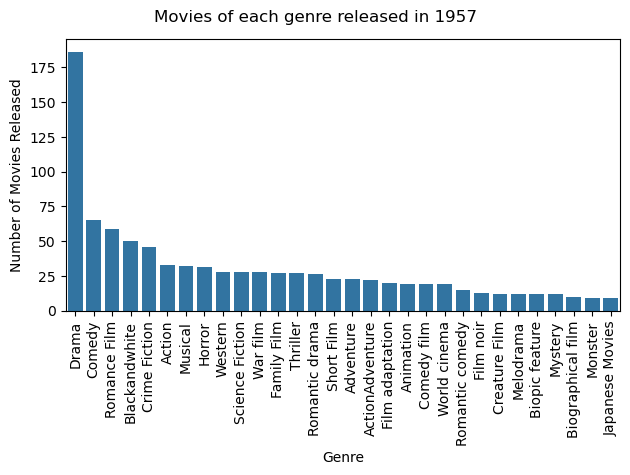

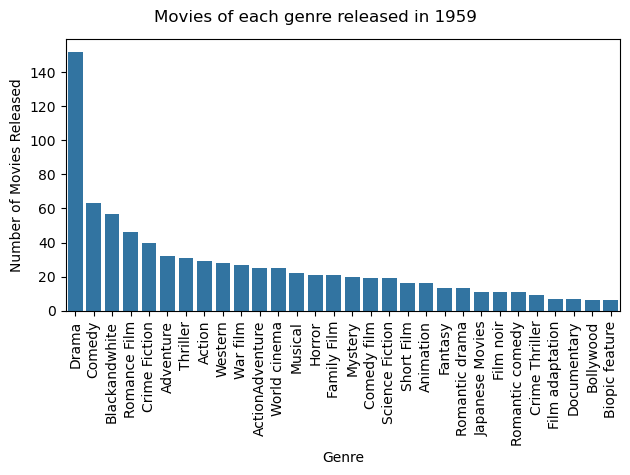

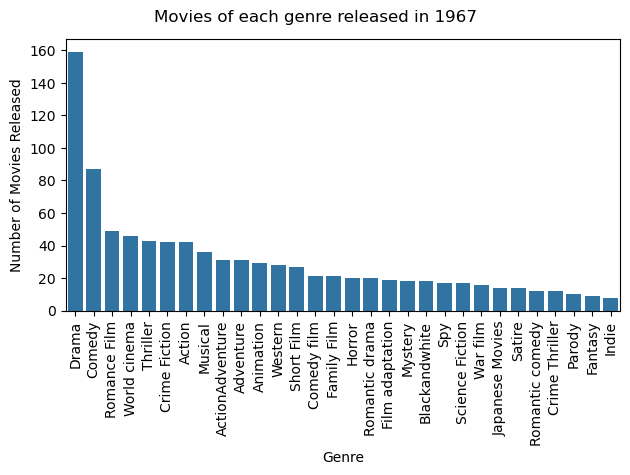

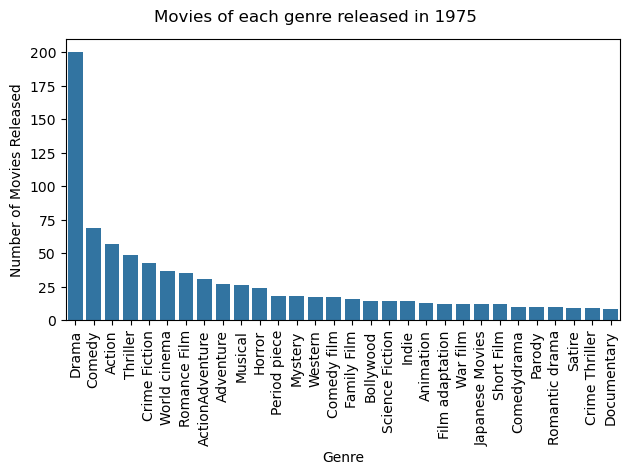

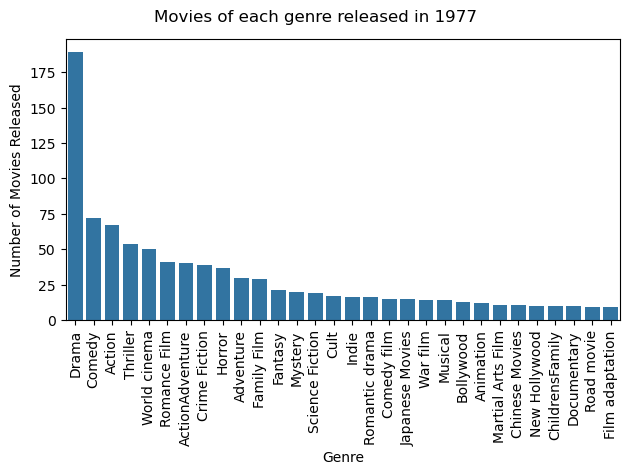

In [26]:
# Initialize years and datafraes for genre counts for each
'''
vietnam_war_rows = final_df[final_df['WarName'].str.contains('Vietnam War', case=False, na=False)].iloc[0]
year1 = vietnam_war_rows["StartYear"]
year3 = vietnam_war_rows["EndYear"]
year0 = year1 - 2
year2 = (year1 + year3) // 2
year4 = year3 + 2
'''

year0, year1, year2, year3, year4 = 1957, 1959, 1967, 1975, 1977

counts_year0, total_movies_year0 = count_genres_by_year(df, year0)
counts_year1, total_movies_year1 = count_genres_by_year(df, year1)
counts_year2, total_movies_year2 = count_genres_by_year(df, year2)
counts_year3, total_movies_year3 = count_genres_by_year(df, year3)
counts_year4, total_movies_year4 = count_genres_by_year(df, year4)

# Calculating genre differences
print("Genre Counts:")
VW_0_genres = count_genres_by_year(df, year0)[0].head(30)
VW_1_genres = count_genres_by_year(df, year1)[0].head(30)
VW_2_genres = count_genres_by_year(df, year2)[0].head(30)
VW_3_genres = count_genres_by_year(df, year3)[0].head(30)
VW_4_genres = count_genres_by_year(df, year4)[0].head(30)

sns.barplot(data = VW_0_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1957")
sns.barplot(data = VW_1_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1959")
sns.barplot(data = VW_2_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1967")
sns.barplot(data = VW_3_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1975")
sns.barplot(data = VW_4_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1977")

Here the abosulte growth was calculated for the pairs of consecutive year from the list: 1957, 1959, 1967, 1975, 1977. 

From 1959 to 1967 the War Film genre takes second place as the genre with the biggest absolute growth. However, from 1967 to 1975 the War Film genre is now at the 20th place, while the Spy genre entered the top 5. Interestingly, from the end of the war in 1975 to the year of 1975 both Spy and War Film genres are no longer in the top 30, however genres Superhero movie and Superhero entered the top, taking 18th and 19th place.

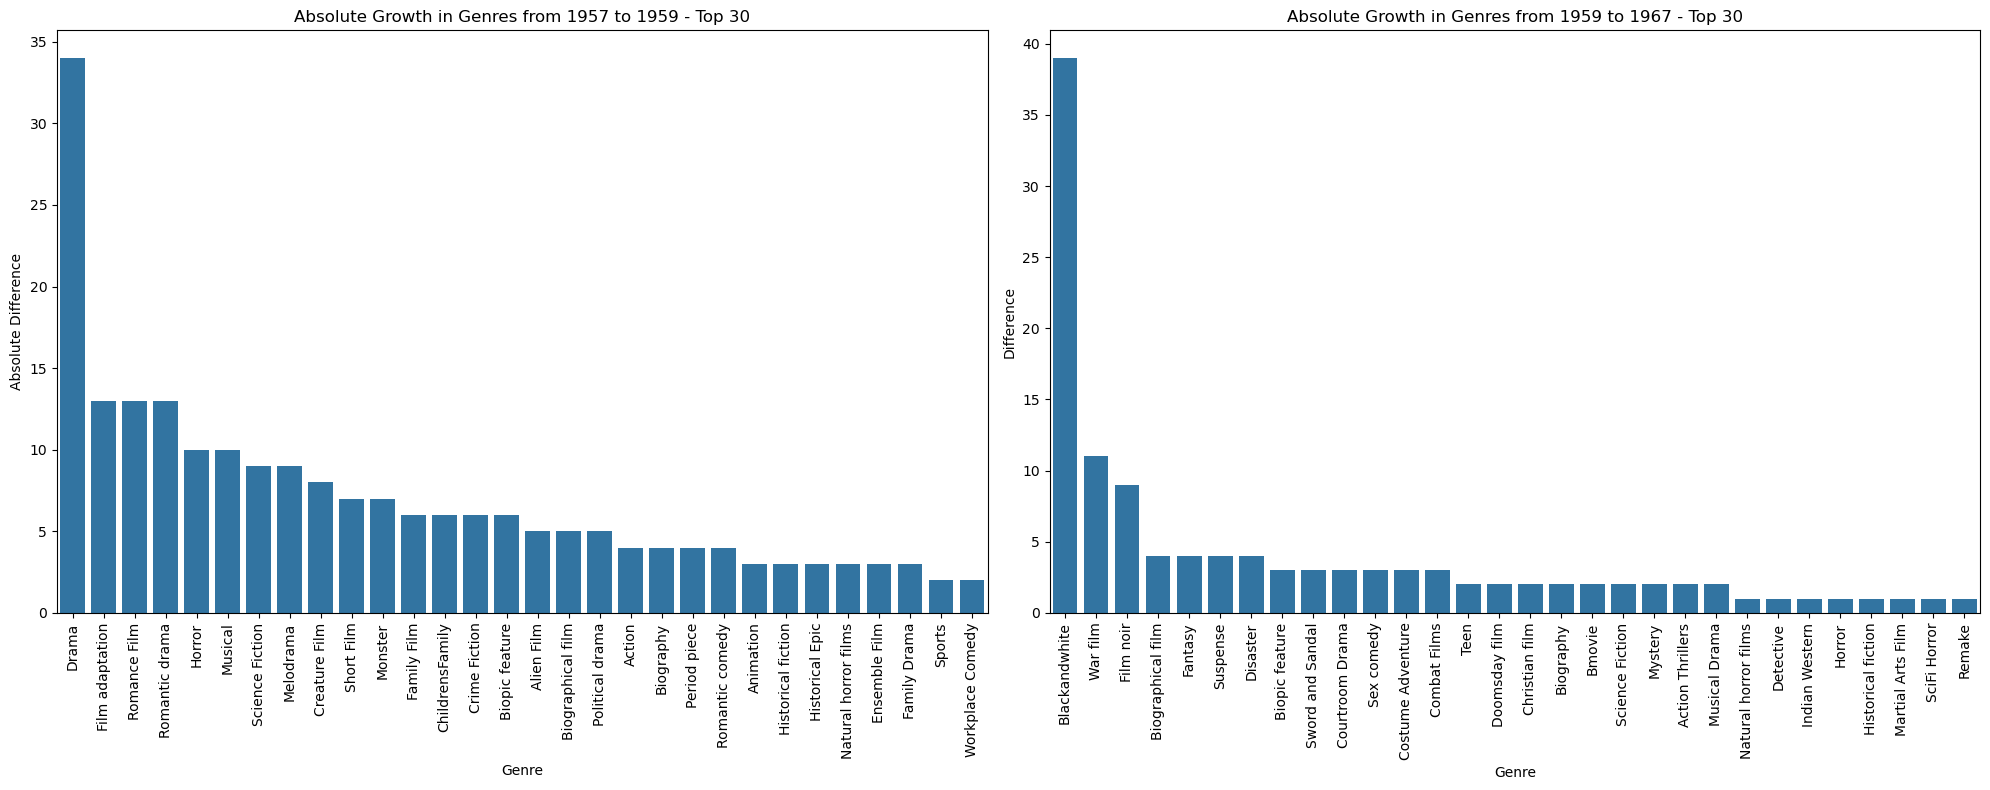

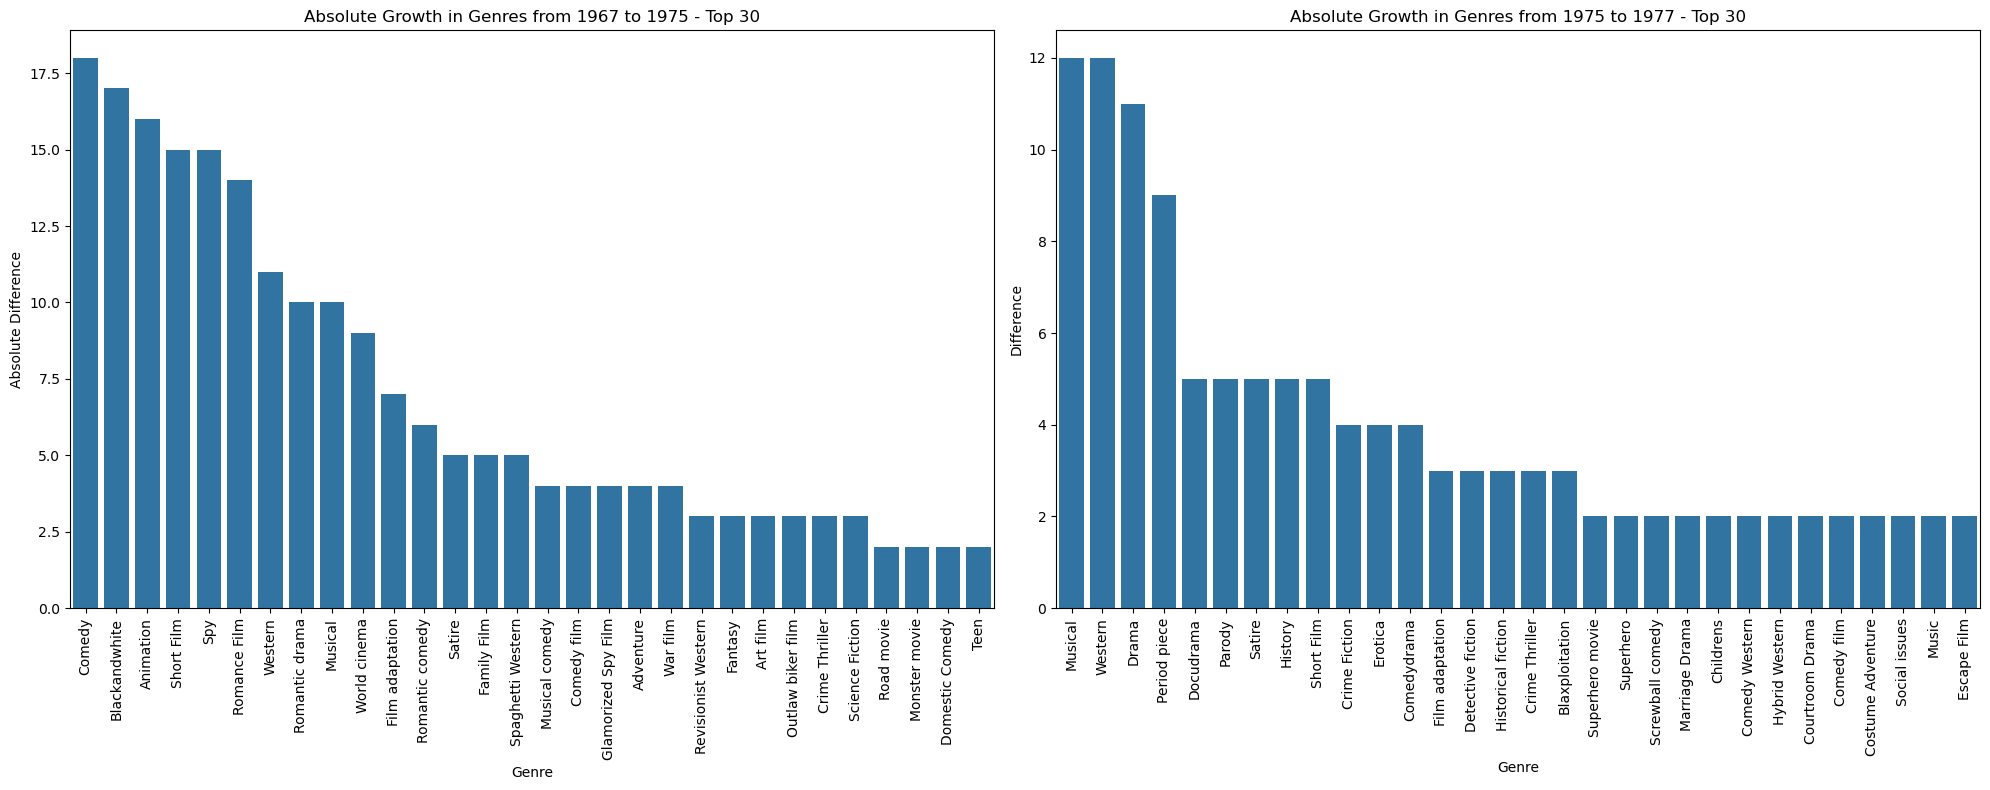

In [27]:
abs_difference_year0_year1 = calc_genre_differences(counts_year0, counts_year1, year0, year1)
abs_difference_year1_year2 = calc_genre_differences(counts_year1, counts_year2, year1, year2)
abs_difference_year2_year3 = calc_genre_differences(counts_year2, counts_year3, year2, year3)
abs_difference_year3_year4 = calc_genre_differences(counts_year3, counts_year4, year3, year4)

# Create subplots with two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# First plot: Absolute difference for year1 and year2
sns.barplot(data=abs_difference_year0_year1.head(30), x="Genre", y="Difference", ax=axes[0])
axes[0].set_title(f"Absolute Growth in Genres from {year0} to {year1} - Top 30")
axes[0].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Second plot: Absolute difference for year2 and year3
sns.barplot(data=abs_difference_year1_year2.head(30), x="Genre", y="Difference", ax=axes[1])
axes[1].set_title(f"Absolute Growth in Genres from {year1} to {year2} - Top 30")
axes[1].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Adjust layout to prevent overlap and ensure both plots fit within the figure
plt.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# First plot: Absolute difference for year1 and year2
sns.barplot(data=abs_difference_year2_year3.head(30), x="Genre", y="Difference", ax=axes[0])
axes[0].set_title(f"Absolute Growth in Genres from {year2} to {year3} - Top 30")
axes[0].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Second plot: Absolute difference for year2 and year3
sns.barplot(data=abs_difference_year3_year4.head(30), x="Genre", y="Difference", ax=axes[1])
axes[1].set_title(f"Absolute Growth in Genres from {year3} to {year4} - Top 30")
axes[1].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Adjust layout to prevent overlap and ensure both plots fit within the figure
plt.tight_layout()
plt.show()
plt.close()

We calculate the growth of a genre in percentage to account for some natural growth the most popular genres like Drama and Comedy always have in comparison to other more specific genres. The line plots are build for the top 30 and bottom 30.\
Note: Here the genres that created an infinite percentage increase (from 0 to any other number) were deleted. The genres with a -100 were deleted due to their small values as well.

Throughout the years of the Vietnam War Spy genre had the biggest growth of 325%. Meanwhile the War Film genre is in the bottom 30 with a 40.7% decrease.

        Genre  Count_1959  Count_1967  Difference  Percentage_Increase
132  War film        27.0        16.0       -11.0           -40.740741


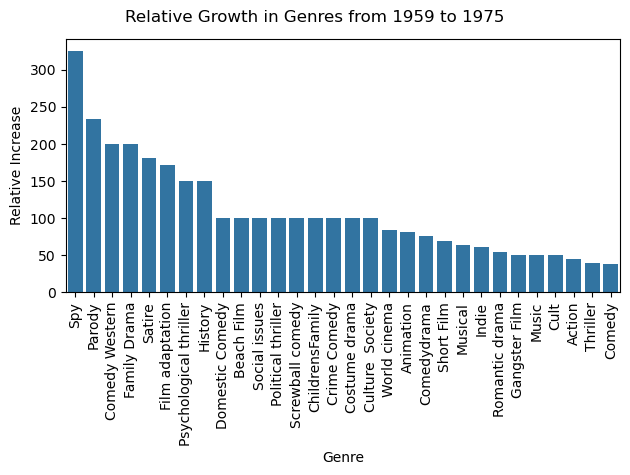

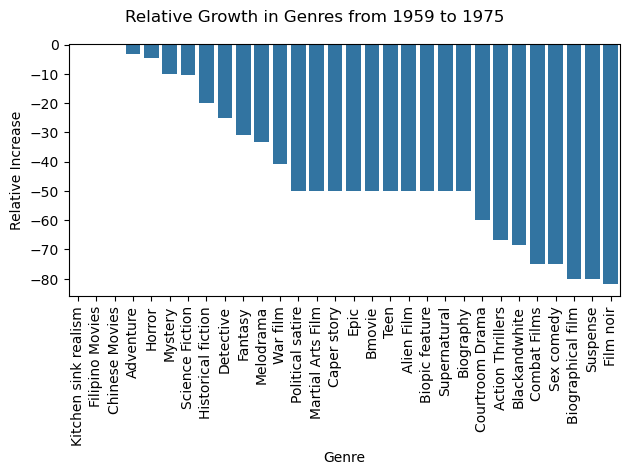

In [28]:
relative_growth = calc_genre_growth(counts_year1, counts_year2, year1, year2)
relative_growth['Percentage_Increase'] = relative_growth['Percentage_Increase'].replace([np.inf, -np.inf], np.nan)
relative_growth = relative_growth.dropna(subset=['Percentage_Increase'])
relative_growth = relative_growth[relative_growth['Percentage_Increase'] != -100]
print(relative_growth[relative_growth["Genre"] == "War film"])
sns.barplot(data = relative_growth.head(30), x = "Genre", y = "Percentage_Increase")
name_plot("Relative Increase", "Relative Growth in Genres from 1959 to 1975")
sns.barplot(data = relative_growth.tail(30), x = "Genre", y = "Percentage_Increase")
name_plot("Relative Increase", "Relative Growth in Genres from 1959 to 1975")

Here we analyze the proportion growth of the movie genres to take into account the proportion each genre constituted of the overall number of movies released that year. Interestengly, the growth in the proportion of Spy Movies from 1959 to 1975 takes second place, while Glamorized Spy Movie is another genre that made it into the top 30. However, interestingly, the War Films genre had the 3rd highest decrease in proportion over the years of the Vietnam War.

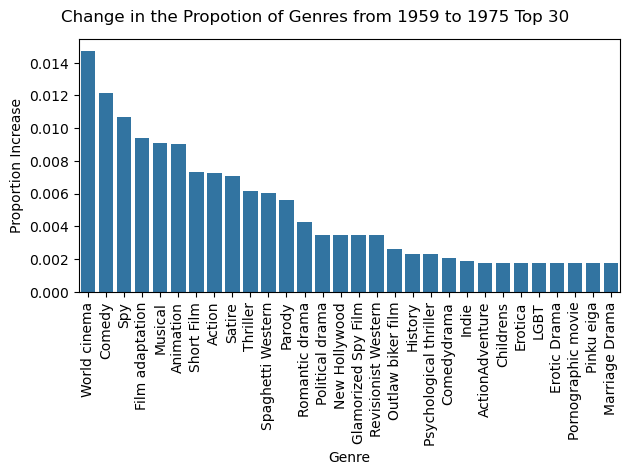

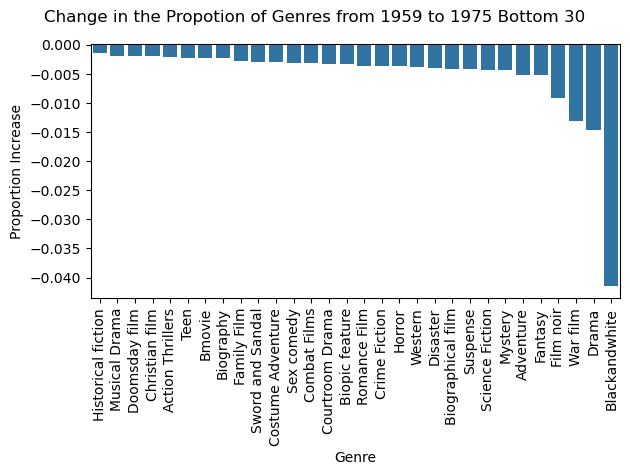

In [29]:
proportion_growth = calc_proportion_growth(counts_year1, counts_year2, year1, year2, total_movies_year1, total_movies_year2)
sns.barplot(data = proportion_growth.head(30), x = "Genre", y = "Proportion_Difference")
name_plot("Proportion Increase", "Change in the Propotion of Genres from 1959 to 1975 Top 30")

sns.barplot(data = proportion_growth.tail(30), x = "Genre", y = "Proportion_Difference")
name_plot("Proportion Increase", "Change in the Propotion of Genres from 1959 to 1975 Bottom 30")

Here we analyze the number of War Films released every year and build a line plot. Some interesting findings from the ine plot and the top 20 years with the most War Films released are that biggest spike in War films except during World War 2 happened in the year of 2007. Moreover the period of 2006-2008 constitutes the top 5 years for the War Films. During those time the Iraq War was still ongoing and it is considered that the year of 2007 was the year of the biggest death toll for the war. Moreover, 2006 was the year when the Lebanon War happened. Overall, the 2000s take up almost half of the top, which could also be associated with the Afghanistan War

We can also notice that the years related to the event of our current analysis - the Vietnam War - are also in the top 30 for the War Films genre. The year 1958 is at highest 11th place out of all, and meanwhile the U.S. entered the Vietnam War in 1959, before that it funded the South Vietnam in the Civil War, which started in 1957 (16th on the list, taking 2nd place for the Vietnam War years). It is also important to note, however, that the U.S. invasion of Lebanon also happened in 1958.

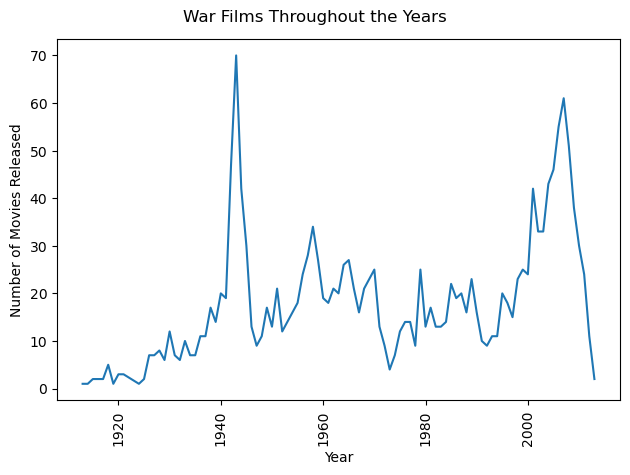

    Year  Count
0   1943     70
1   2007     61
2   2006     55
3   2008     51
4   1942     47
5   2005     46
6   2004     43
7   1944     42
8   2001     42
9   2009     38
10  1958     34
11  2002     33
12  2003     33
13  1945     30
14  2010     30
15  1957     28
16  1959     27
17  1965     27
18  1964     26
19  1970     25
    Year  Count
0   1913      1
1   1914      1
2   1919      1
3   1924      1
4   1915      2
5   1917      2
6   1925      2
7   2013      2
8   1920      3
9   1921      3
10  1973      4
11  1918      5
12  1929      6
13  1932      6
14  1926      7
15  1927      7
16  1931      7
17  1934      7
18  1935      7
19  1974      7


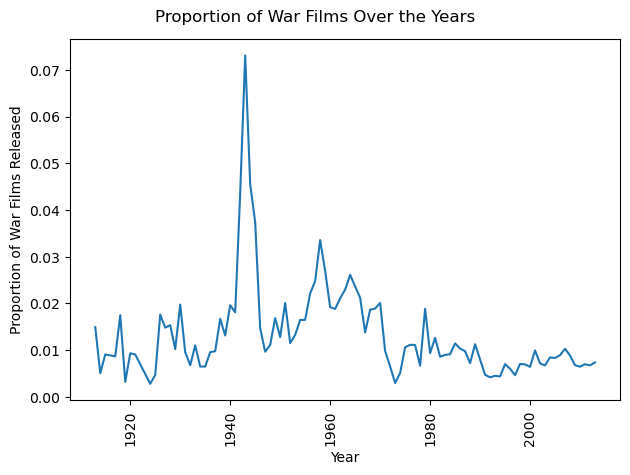

    Year  Count  Total  Proportion
27  1943     70    958    0.073069
28  1944     42    922    0.045553
26  1942     47   1078    0.043599
29  1945     30    803    0.037360
42  1958     34   1013    0.033564
43  1959     27   1001    0.026973
48  1964     26    995    0.026131
41  1957     28   1129    0.024801
49  1965     27   1142    0.023643
47  1963     20    871    0.022962
40  1956     24   1083    0.022161
50  1966     21    989    0.021234
46  1962     21    995    0.021106
54  1970     25   1243    0.020113
35  1951     21   1045    0.020096
14  1930     12    607    0.019769
24  1940     20   1019    0.019627
44  1960     19    989    0.019211
53  1969     23   1216    0.018914
63  1979     25   1327    0.018839
    Year  Count  Total  Proportion
8   1924      1    355    0.002817
57  1973      4   1340    0.002985
5   1919      1    309    0.003236
76  1992      9   2139    0.004208
78  1994     11   2499    0.004402
77  1993     11   2432    0.004523
81  1997     15   32

In [30]:
war_films = count_genre_over_years(df, "War film")
sns.lineplot(data = war_films, x = "Year", y = "Count")
name_plot("Number of Movies Released", "War Films Throughout the Years")
print(top_years_for_genre(war_films, 20).reset_index(drop=True))
print(bottom_years_for_genre(war_films, 20).reset_index(drop=True))

# Get the proportion of War Films for each year
war_films_proportion = count_genre_proportion(df, "War film")

# Plot the proportion of War Films over the years
sns.lineplot(data=war_films_proportion, x="Year", y="Proportion")
name_plot("Proportion of War Films Released", "Proportion of War Films Over the Years")

# Print top 20 years with the highest proportion of War Films
print(war_films_proportion.nlargest(20, 'Proportion'))

# Print bottom 20 years with the lowest proportion of War Films
print(war_films_proportion.nsmallest(20, 'Proportion'))


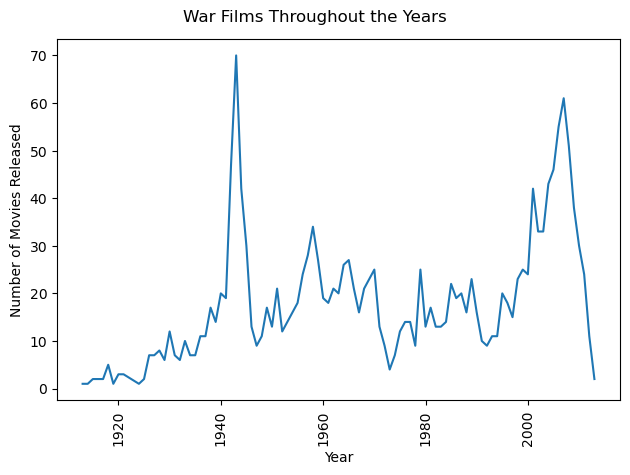

    Year  Count
0   1943     70
1   2007     61
2   2006     55
3   2008     51
4   1942     47
5   2005     46
6   2004     43
7   1944     42
8   2001     42
9   2009     38
10  1958     34
11  2002     33
12  2003     33
13  1945     30
14  2010     30
15  1957     28
16  1959     27
17  1965     27
18  1964     26
19  1970     25
    Year  Count
0   1913      1
1   1914      1
2   1919      1
3   1924      1
4   1915      2
5   1917      2
6   1925      2
7   2013      2
8   1920      3
9   1921      3
10  1973      4
11  1918      5
12  1929      6
13  1932      6
14  1926      7
15  1927      7
16  1931      7
17  1934      7
18  1935      7
19  1974      7


In [31]:
war_films = count_genre_over_years(df, "War film")
sns.lineplot(data = war_films, x = "Year", y = "Count")
name_plot("Number of Movies Released", "War Films Throughout the Years")
print(top_years_for_genre(war_films, 20).reset_index(drop=True))
print(bottom_years_for_genre(war_films, 20).reset_index(drop=True))

Noticing that the revenue values are often missing, let's discover the number of data we have for revenue.

In [32]:
print(df["Revenue"].count())
print(df.shape[0])

8038
47395


## 2. Research Question 2

How do movie genre preferences differ between countries in conflict or those experiencing similar global events?

In [33]:
# Import the data
data = pd.read_table("data/movies_with_summaries.csv", sep=",")
data.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
0,975900,tt0228333,Ghosts of Mars,Ghosts of Mars,2001-08-24,2001,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","['Action,Horror,Sci-Fi']",4.9,58872,14010832.0,98.0,['English Language'],['United States of America'],"Set in the second half of the 22nd century, th..."
1,261236,tt0083949,A Woman in Flames,Die flambierte Frau,1983,1983,['Drama'],['Drama'],5.9,648,NaN,106.0,['German Language'],['Germany'],"Eva, an upper class housewife, becomes frustra..."
2,171005,tt0097499,Henry V,Henry V,1989-11-08,1989,"['Costume drama', 'War film', 'Epic', 'Period ...","['Biography,Drama,History']",7.5,32088,10161099.0,137.0,['English Language'],['United Kingdom'],{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
3,77856,tt0058331,Mary Poppins,Mary Poppins,1964-08-27,1964,"['ChildrensFamily', 'Musical', 'Fantasy', 'Com...","['Comedy,Family,Fantasy']",7.8,189202,102272727.0,139.0,['English Language'],['United States of America'],The film opens with Mary Poppins perched in a...
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],['Drama'],7.7,24,NaN,108.0,['German Language'],['German Democratic Republic'],"Otto Brosowski, a communist miner, writes to t..."


In [34]:
data['Genres'] = data['Genres'].fillna("[]")
data['Genres'] = data['Genres'].str.strip("[]").str.replace("'", "").str.split(", ")

data['Genres_IMDb'] = data['Genres_IMDb'].fillna("[]")
data['Genres_IMDb'] = data['Genres_IMDb'].str.strip("[]").str.replace("'", "").str.split(",")

data['Countries'] = data['Countries'].fillna("[]")
data['Countries'] = data['Countries'].str.strip("[]").str.replace("'", "").str.split(", ")

data.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
0,975900,tt0228333,Ghosts of Mars,Ghosts of Mars,2001-08-24,2001,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Horror, Sci-Fi]",4.9,58872,14010832.0,98.0,['English Language'],[United States of America],"Set in the second half of the 22nd century, th..."
1,261236,tt0083949,A Woman in Flames,Die flambierte Frau,1983,1983,[Drama],[Drama],5.9,648,NaN,106.0,['German Language'],[Germany],"Eva, an upper class housewife, becomes frustra..."
2,171005,tt0097499,Henry V,Henry V,1989-11-08,1989,"[Costume drama, War film, Epic, Period piece, ...","[Biography, Drama, History]",7.5,32088,10161099.0,137.0,['English Language'],[United Kingdom],{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
3,77856,tt0058331,Mary Poppins,Mary Poppins,1964-08-27,1964,"[ChildrensFamily, Musical, Fantasy, Comedy, Dr...","[Comedy, Family, Fantasy]",7.8,189202,102272727.0,139.0,['English Language'],[United States of America],The film opens with Mary Poppins perched in a...
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],[Drama],7.7,24,NaN,108.0,['German Language'],[German Democratic Republic],"Otto Brosowski, a communist miner, writes to t..."


Our data has two columns related to genres, one coming from the CMU dataset, and one coming from the IMDb dataset.   

In [35]:
all_genres = data['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count = Counter([genre.strip() for genres in all_genres for genre in genres])
genres_list = genres_count.keys()
len(genres_list)

352

In [36]:
genres_list

dict_keys(['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western', 'Drama', 'Costume drama', 'War film', 'Epic', 'Period piece', 'Film adaptation', 'ChildrensFamily', 'Musical', 'Fantasy', 'Comedy', 'Family Film', 'Childrens Fantasy', '', 'Romantic comedy', 'Romance Film', 'Indie', 'Crime Fiction', 'Coming of age', 'World cinema', 'Romantic drama', 'Bollywood', 'Black comedy', 'ActionAdventure', 'Cult', 'Adventure Comedy', 'Slapstick', 'Sports', 'Family Drama', 'Comedydrama', 'Biographical film', 'Historical fiction', 'Blackandwhite', 'Biopic feature', 'Culture  Society', 'Biography', 'Documentary', 'Christmas movie', 'Television movie', 'Action Comedy', 'Blaxploitation', 'Martial Arts Film', 'Erotica', 'SciFi Horror', 'Psychological thriller', 'Satire', 'Western', 'Softcore Porn', 'Sexploitation', 'Mystery', 'Crime Thriller', 'Action Thrillers', 'Suspense', 'Musical Drama', 'Film noir', 'Experimental film', 'Surrealism', 'Tragicomedy', 'Avantga

In [37]:
all_genres_imdb = data['Genres_IMDb'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_imdb = Counter([genre.strip() for genres in all_genres_imdb for genre in genres])
genres_list_imdb = genres_count_imdb.keys()
len(genres_list_imdb)

27

It is easy to see that both columns have their advantages and disadvantages: the `Genres` column, coming from the CMU dataset, has several more classes compared to the `Genres_IMDb` column, derived from the IMDb dataset (356 vs 27), and this strong difference can have both positive and negative effects based on the task at hand.   
Due to the very high amount of different classes, several of them are considerably similar to one-another (an example can be given by 'Crime Thriller', 'Crime Drama', 'Crime Comedy', 'Law  Crime', 'Crime', 'Master Criminal Films',... - here all the movies could be put under the common tag 'Crime'), and this could lead to some problems in the use of some models.   
On the other hand, in some more targeted analysis - such as the one we face in this section - the few classes provided by the IMDb dataset don't allow any conclusion on very specific subtopics, which is why in this section the column on which we will focus our analysis is the column `Genres`.

### Genres Distribution by Year

A first tool of our analysis is a chronological filtering, using the `Release_Date` and `Year` columns.   
We selected two subsets of movies, the ones produced in the 1960s and those produced in the XXI century, and we look at the differences in movie genres between these two periods of time.

In [38]:
movies_60s = data[(data['Year'] < 1970) & (data['Year'] >= 1960)]
movies_2000s = data[data['Year'] >= 2000]
movies_60s.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
3,77856,tt0058331,Mary Poppins,Mary Poppins,1964-08-27,1964,"[ChildrensFamily, Musical, Fantasy, Comedy, Dr...","[Comedy, Family, Fantasy]",7.8,189202,102272727.0,139.0,['English Language'],[United States of America],The film opens with Mary Poppins perched in a...
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],[Drama],7.7,24,NaN,108.0,['German Language'],[German Democratic Republic],"Otto Brosowski, a communist miner, writes to t..."
28,5664529,tt0063787,Vixen!,Vixen!,1968,1968,"[Softcore Porn, Sexploitation]",[Drama],5.6,3185,NaN,70.0,['English Language'],[United States of America],"In the heart of the Canadian wilderness, sultr..."
30,12788657,tt0062755,The Boston Strangler,The Boston Strangler,1968,1968,"[Crime Fiction, Mystery, Thriller, Drama, Crim...","[Crime, Drama, Mystery]",7.0,11083,17810894.0,116.0,['English Language'],[United States of America],The first part of the film shows the police in...
41,7767613,tt0063642,Star!,Star!,1968-07-18,1968,"[Biography, Musical, Drama, Biopic feature, Bi...","[Biography, Comedy, Drama]",6.4,2304,4000000.0,176.0,['English Language'],[United States of America],"The film opens in 1940, with Lawrence in a scr..."


In [39]:
all_genres_60s = movies_60s['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_60s = Counter([genre.strip() for genres in all_genres_60s for genre in genres])
genres_count_60s_reduced = dict(genres_count_60s.most_common(30))
genres_count_60s_reduced

{'Drama': 943,
 'Comedy': 515,
 'Romance Film': 317,
 'World cinema': 257,
 'Action': 246,
 'Thriller': 221,
 'ActionAdventure': 217,
 'Adventure': 210,
 'Crime Fiction': 187,
 'Musical': 170,
 'Family Film': 166,
 'Blackandwhite': 161,
 'Horror': 154,
 'Western': 132,
 'Science Fiction': 129,
 'War film': 128,
 'Animation': 128,
 'Romantic drama': 118,
 'Short Film': 117,
 'Romantic comedy': 113,
 'Film adaptation': 112,
 'Mystery': 81,
 'Japanese Movies': 80,
 'Fantasy': 77,
 'Bollywood': 66,
 'Indie': 63,
 'Crime Thriller': 61,
 'Spy': 61,
 'Parody': 57,
 'Satire': 56}

In [40]:
all_genres_2000s = movies_2000s['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_2000s = Counter([genre.strip() for genres in all_genres_2000s for genre in genres])
genres_count_2000s_reduced = dict(genres_count_2000s.most_common(30))
genres_count_2000s_reduced

{'Drama': 5987,
 'Comedy': 3103,
 'Thriller': 2636,
 'Romance Film': 2323,
 'World cinema': 2059,
 'Action': 2000,
 'Indie': 1420,
 'Horror': 1407,
 'Crime Fiction': 1306,
 'ActionAdventure': 1200,
 'Adventure': 970,
 'Romantic drama': 954,
 'Family Film': 901,
 'Romantic comedy': 797,
 'Science Fiction': 772,
 'Fantasy': 772,
 'Mystery': 763,
 'Crime Thriller': 652,
 'Musical': 617,
 'Period piece': 545,
 'Animation': 536,
 'Psychological thriller': 487,
 'Comedydrama': 473,
 'Documentary': 431,
 'Comedy film': 428,
 'Film adaptation': 410,
 'Bollywood': 385,
 'Teen': 373,
 'LGBT': 371,
 'Television movie': 350}

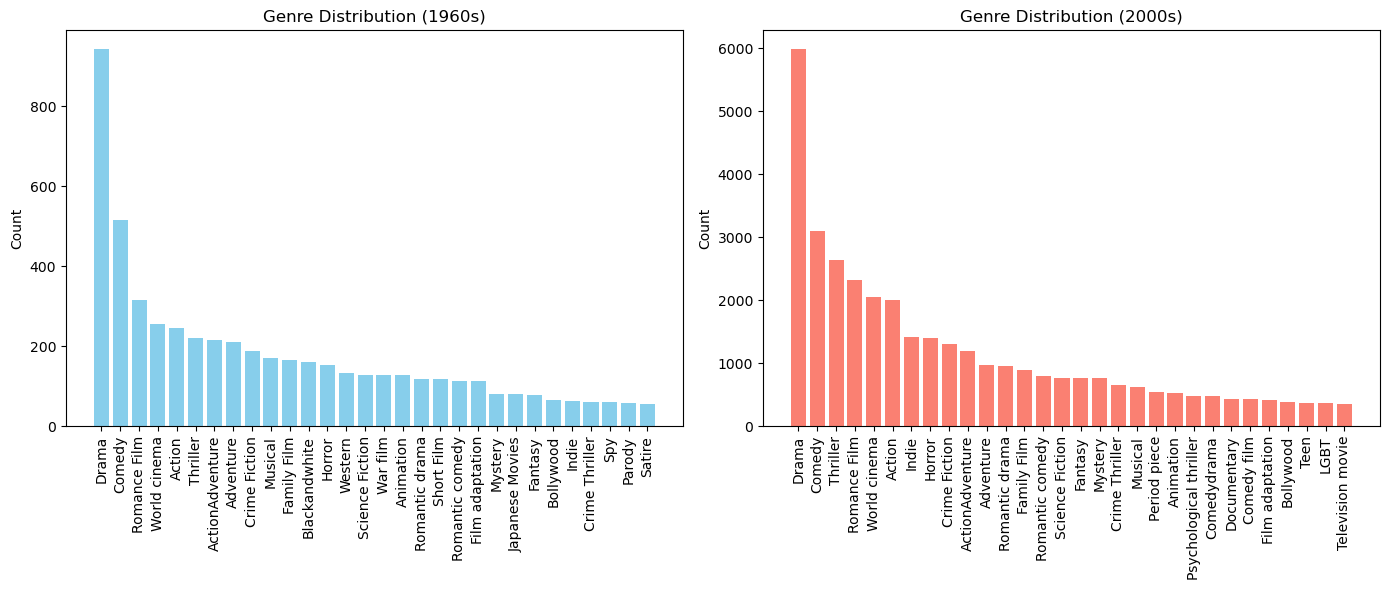

In [41]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for 1960s
axes[0].bar(genres_count_60s_reduced.keys(), genres_count_60s_reduced.values(), color='skyblue')
axes[0].set_title('Genre Distribution (1960s)')
axes[0].set_xticklabels(genres_count_60s_reduced.keys(), rotation=90)
axes[0].set_ylabel('Count')

# Plot for 2000s
axes[1].bar(genres_count_2000s_reduced.keys(), genres_count_2000s_reduced.values(), color='salmon')
axes[1].set_title('Genre Distribution (2000s)')
axes[1].set_xticklabels(genres_count_2000s_reduced.keys(), rotation=90)
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

By looking at the most common genres in both time periods, it is easy to see some significant differences between the two histogram plots:
- The overall number of produced movies has increased a lot iver time, so much that the least common movie genre in the 2000s plot (Film Adaptation, with 466 movies) has more elements than the third most common genre in the 60s (Romance Film, with 448 movies).   
- Some movie genres have disappeared from the most common ones (such as Black and White movies or Westerns), leaving space to others touching themes more relevant to the common era (such as 'LGBT' and 'Sports')

### Genres Distribution by Country

A second approach to our analysis is driven by the elements in the column `Countries`: are the distributions between genres different between the various countries where they are produced? We will do a quick analysis of USA and Russia, two countries which historically are confronted in several contexts.

In [42]:
us_movies = data[data['Countries'].apply(lambda x: 'United States of America' in x if isinstance(x, list) else False)]
russia_movies = data[data['Countries'].apply(lambda x: 'Russia' in x or 'Soviet Union' in x if isinstance(x, list) else False)]
russia_movies.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
619,19972307,tt0476695,The Sovereign's Servant,Sluga Gosudarev,2007-02-20,2007,"[History, Action, Adventure, War film]","[Action, Adventure, History]",5.8,1484,NaN,131.0,"['French Language', 'Polish Language', 'Russia...",[Russia],Tha action takes place at the time of the Swed...
703,17243300,tt0073927,"Hello, I'm Your Aunt!","Zdravstvuyte, ya vasha tyotya!",1975,1975,"[Musical, Comedy]",[Comedy],7.4,1871,NaN,98.0,['Russian Language'],[Soviet Union],The action takes place at the beginning of 20t...
1167,30665531,tt0200267,The Rifleman of the Voroshilov Regiment,Voroshilovskiy strelok,1999,1999,"[Crime Fiction, Drama]","[Crime, Drama]",7.4,5087,NaN,100.0,['Russian Language'],[Russia],World War II veteran Ivan Afonin lives with hi...
1263,26978561,tt0403645,Burnt by the Sun 2,Utomlennye solntsem 2,2010-04-17,2010,"[Drama, World cinema]","[Drama, History, War]",4.3,4529,8266778.0,180.0,['Russian Language'],"[France, Russia, Germany]",The film begins in June 1941. Five years have...
1753,26284851,tt1740033,The Book of Masters,The Book of Masters,2009,2009,[Fantasy],[Adventure],6.4,15,NaN,100.0,['Russian Language'],[Russia],"A beautiful and kind girl, daughter of Baba Ya..."


In [43]:
all_genres_us = us_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_us = Counter([genre.strip() for genres in all_genres_us for genre in genres])
genres_count_us_reduced = dict(genres_count_us.most_common(30))
genres_count_us_reduced

{'Drama': 7883,
 'Comedy': 5525,
 'Thriller': 3669,
 'Action': 3111,
 'Romance Film': 3076,
 'Crime Fiction': 2407,
 'ActionAdventure': 2326,
 'Indie': 2125,
 'Blackandwhite': 2095,
 'Adventure': 2093,
 'Horror': 1998,
 'Family Film': 1905,
 'Science Fiction': 1386,
 'Romantic comedy': 1347,
 'Mystery': 1296,
 'Fantasy': 1145,
 'Crime Thriller': 1122,
 'Animation': 1057,
 'Romantic drama': 1050,
 'Musical': 930,
 'Film adaptation': 921,
 'Period piece': 830,
 'Comedydrama': 778,
 'Western': 768,
 'Psychological thriller': 764,
 'Short Film': 746,
 'War film': 711,
 'Teen': 636,
 'ChildrensFamily': 595,
 'Black comedy': 515}

In [44]:
all_genres_russia = russia_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_russia = Counter([genre.strip() for genres in all_genres_russia for genre in genres])
genres_count_russia_reduced = dict(genres_count_russia.most_common(30))
genres_count_russia_reduced

{'Drama': 94,
 'World cinema': 55,
 'Comedy': 28,
 'Romance Film': 25,
 'War film': 24,
 'Action': 23,
 'Fantasy': 20,
 'Thriller': 17,
 'Adventure': 15,
 'Crime Fiction': 15,
 'Science Fiction': 13,
 'History': 12,
 'Animation': 11,
 'Romantic drama': 9,
 'ActionAdventure': 8,
 'Art film': 7,
 'Family Film': 7,
 'Horror': 7,
 'Biographical film': 6,
 'Period piece': 6,
 'Blackandwhite': 5,
 'Short Film': 5,
 'Political drama': 5,
 'Japanese Movies': 5,
 'Mystery': 5,
 'Silent film': 4,
 'Supernatural': 4,
 'Indie': 4,
 'Gangster Film': 4,
 'Musical': 3}

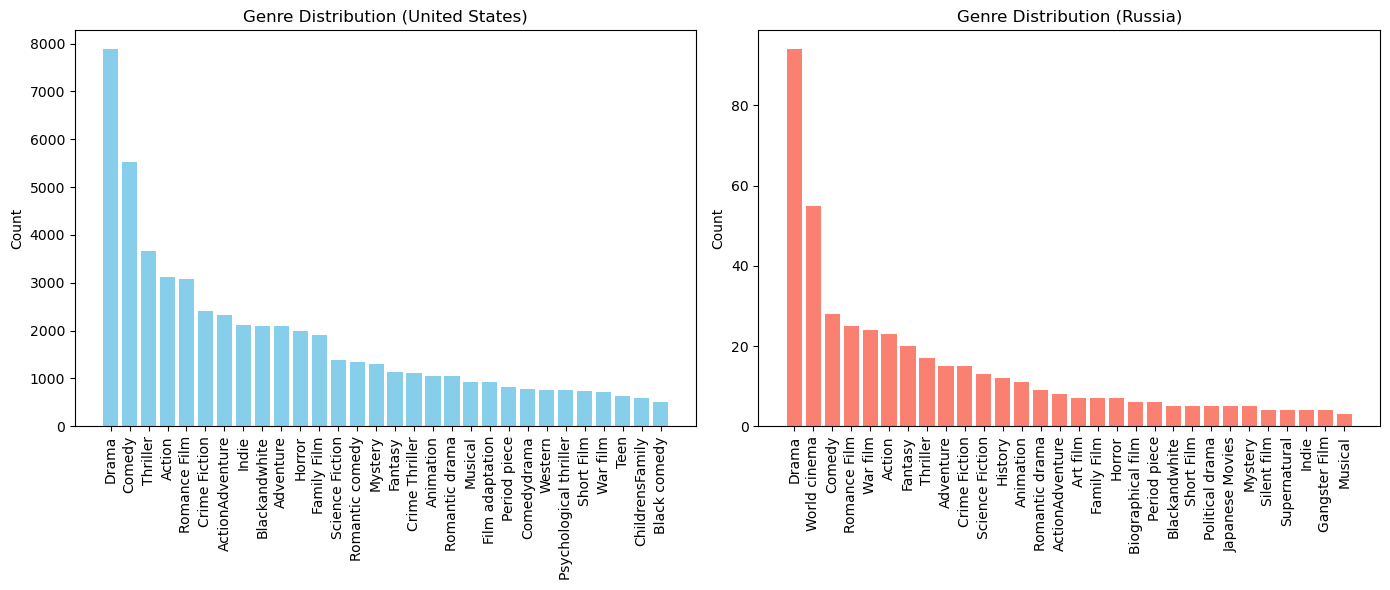

In [45]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for USA
axes[0].bar(genres_count_us_reduced.keys(), genres_count_us_reduced.values(), color='skyblue')
axes[0].set_title('Genre Distribution (United States)')
axes[0].set_xticklabels(genres_count_us_reduced.keys(), rotation=90)
axes[0].set_ylabel('Count')

# Plot for Russia
axes[1].bar(genres_count_russia_reduced.keys(), genres_count_russia_reduced.values(), color='salmon')
axes[1].set_title('Genre Distribution (Russia)')
axes[1].set_xticklabels(genres_count_russia_reduced.keys(), rotation=90)
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Similarly to the chronological analysis from the previous section, the most common genres stay pretty much the same between various countries, but we can see some slight differences between the two countries in exam:
- War films are much more common in Russia rather than in the USA, being 5th in popularity in Russia and only 25th in the USA (this however is not necessarily a significant difference, as the total number of movies in the two datasets are in completely different scales)
- Some genres such as Family Film are fairly common in the USA, while they are almost at the bottom of the list in Russia
- Genres like Westerns and Japanese Movies are geographically restricted to their respective countries, effect which is reflected by the above histograms.

### Genres Distribution by Year and Country

An additional step would be to combine the two analyses, filtering the dataset by both `Country` and `Year`.   
In this section we check for significant differences between the pair of USA and Russia vs the rest of the world, in the time period of the 1960s.

In [46]:
cw_movies = data[
    ((data['Countries'].apply(lambda x: 'United States of America' in x if isinstance(x, list) else False)) | (data['Countries'].apply(lambda x: 'Russia' in x or 'Soviet Union' in x if isinstance(x, list) else False))) & 
    (data['Year'] >= 1960) & (data['Year'] < 1970)]
not_cw_movies = data[
    ((data['Countries'].apply(lambda x: 'United States of America' not in x if isinstance(x, list) else False)) & (data['Countries'].apply(lambda x: 'Russia' not in x and 'Soviet Union' not in x if isinstance(x, list) else False))) & 
    (data['Year'] >= 1960) & (data['Year'] < 1970)]
not_cw_movies.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],[Drama],7.7,24,NaN,108.0,['German Language'],[German Democratic Republic],"Otto Brosowski, a communist miner, writes to t..."
87,7696753,tt0057261,Lord of the Flies,Lord of the Flies,1963-08-13,1963,"[Drama, Adventure, Dystopia, Film adaptation]","[Adventure, Drama, Thriller]",6.9,20788,NaN,90.0,['English Language'],[United Kingdom],"A group of English schoolchildren, living in t..."
116,32345990,tt0058772,Ziddi,Ziddi,1964,1964,"[World cinema, Musical, Drama, Comedy, Romanti...","[Musical, Romance]",6.9,58,NaN,149.0,['Hindi Language'],[India],"On the lookout for employment, Ashok sees the..."
135,235331,tt0058888,Red Beard,Akahige,1965-04,1965,"[Japanese Movies, Art film, World cinema, Blac...",[Drama],8.3,21725,NaN,185.0,['Japanese Language'],[Japan],"The film takes place in Koishikawa, a district..."
139,1249014,tt0056291,Knife in the Water,Nóz w wodzie,1962-03-09,1962,"[Thriller, Marriage Drama, Drama, World cinema]","[Drama, Thriller]",7.4,23986,NaN,94.0,['Polish Language'],[Poland],Andrzej and Krystyna are driving to a lake t...


In [47]:
all_genres_cw = cw_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_cw = Counter([genre.strip() for genres in all_genres_cw for genre in genres])
genres_count_cw_reduced = dict(genres_count_cw.most_common(30))
genres_count_cw_reduced

{'Drama': 479,
 'Comedy': 355,
 'Romance Film': 190,
 'Action': 158,
 'ActionAdventure': 141,
 'Adventure': 133,
 'Family Film': 119,
 'Thriller': 108,
 'Western': 108,
 'Crime Fiction': 99,
 'Romantic comedy': 96,
 'Musical': 89,
 'War film': 88,
 'Animation': 85,
 'Blackandwhite': 82,
 'Horror': 77,
 'Short Film': 76,
 'Film adaptation': 71,
 'Science Fiction': 69,
 'Indie': 52,
 'Mystery': 48,
 'Romantic drama': 46,
 'Fantasy': 39,
 'Parody': 38,
 'Crime Thriller': 36,
 'Spy': 33,
 'Comedydrama': 29,
 'Satire': 28,
 'Cult': 27,
 'Slapstick': 26}

In [48]:
all_genres_not_cw = not_cw_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_not_cw = Counter([genre.strip() for genres in all_genres_not_cw for genre in genres])
genres_count_not_cw_reduced = dict(genres_count_not_cw.most_common(30))
genres_count_not_cw_reduced

{'Drama': 464,
 'World cinema': 240,
 'Comedy': 160,
 'Romance Film': 127,
 'Thriller': 113,
 'Action': 88,
 'Crime Fiction': 88,
 'Musical': 81,
 'Blackandwhite': 79,
 'Adventure': 77,
 'Horror': 77,
 'ActionAdventure': 76,
 'Romantic drama': 72,
 'Japanese Movies': 72,
 'Bollywood': 66,
 'Science Fiction': 60,
 'Family Film': 47,
 'Art film': 45,
 'Animation': 43,
 'Film adaptation': 41,
 'Short Film': 41,
 'War film': 40,
 'Fantasy': 38,
 'Mystery': 33,
 'Comedy film': 32,
 'Satire': 28,
 'Spy': 28,
 'Crime Thriller': 25,
 'Western': 24,
 'Spaghetti Western': 20}

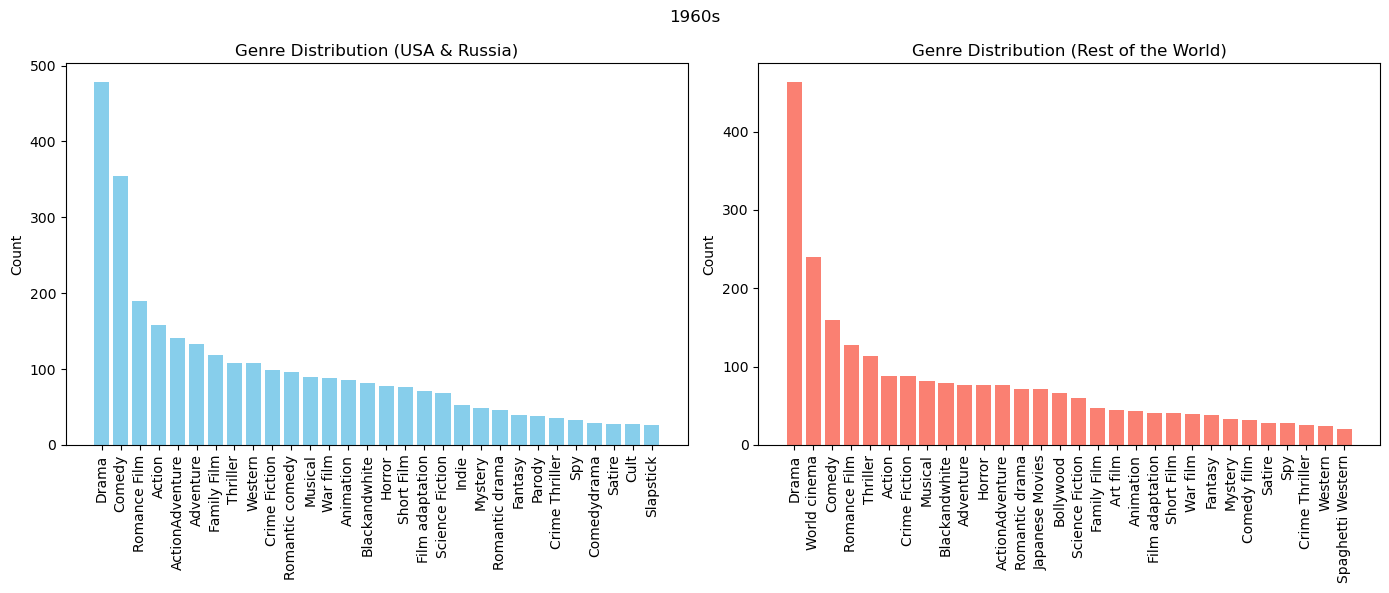

In [49]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for USA and Russia
axes[0].bar(genres_count_cw_reduced.keys(), genres_count_cw_reduced.values(), color='skyblue')
axes[0].set_title('Genre Distribution (USA & Russia)')
axes[0].set_xticklabels(genres_count_cw_reduced.keys(), rotation=90)
axes[0].set_ylabel('Count')

# Plot for Rest of the World
axes[1].bar(genres_count_not_cw_reduced.keys(), genres_count_not_cw_reduced.values(), color='salmon')
axes[1].set_title('Genre Distribution (Rest of the World)')
axes[1].set_xticklabels(genres_count_not_cw_reduced.keys(), rotation=90)
axes[1].set_ylabel('Count')

plt.suptitle("1960s")
plt.tight_layout()
plt.show()

Unfortunately, the two histograms show very few differences between one-another, with `War Film` and `Spy` movies having only a slightly higher position in the list despite being genres with possibly significant relevance to the historical period.   
It is moreover difficult to link this higher position solely to an historical correlation, as on the right histogram we see genres such as 'Japanese Movies' and 'Bollywood' which are inherently limited to the rest of the world.

### Single Genre Analysis

Single Movie genres are also a great driver of the analysis, as they can show some results which we can relate to historical events thanks to outside knowledge, as in the following example for the `Spy` genre:

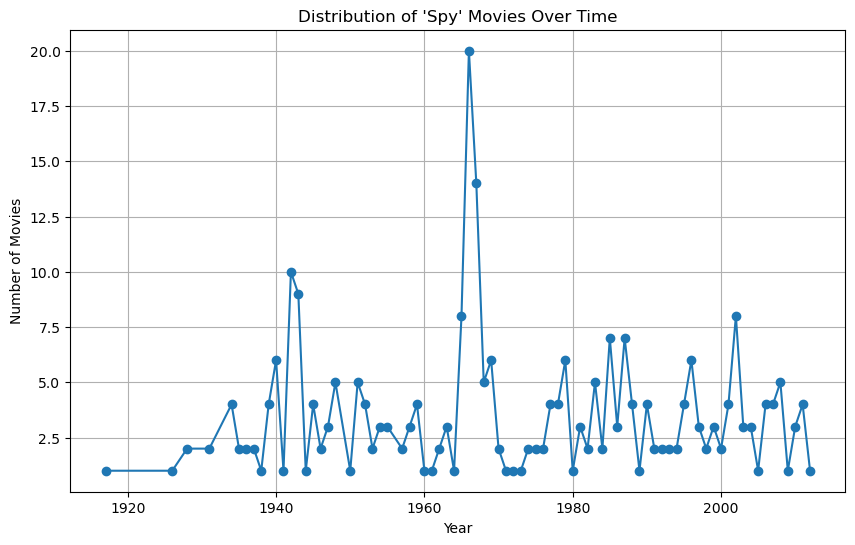

In [50]:
genre_to_plot = "Spy"
genre_movies = data[data['Genres'].apply(lambda x: genre_to_plot in x if isinstance(x, list) else False)]
movies_per_year = genre_movies.groupby('Year').size()
plt.figure(figsize=(10, 6))
plt.plot(movies_per_year.index, movies_per_year.values, marker='o')
plt.title(f"Distribution of '{genre_to_plot}' Movies Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()

In [51]:
sorted_years = dict(sorted(movies_per_year.items(), key=lambda item: item[1], reverse=True))
list(sorted_years.keys())[:10]

[1966, 1967, 1942, 1943, 1965, 2002, 1985, 1987, 1940, 1969]

The timeline for the genre shows two significant peaks near end of WWII (1942-1945) and middle of Cold War (1960s).   
We can explain this phenomena with a brief historical analysis: for example, we can say that in the period of WWII the topic of spies selling information to the enemies, as well as enemies stealing or intercepting information important for winning the war was a common fear among both Allies and Axis. This could have lead to the topic becoming part of the everyday life for a lot of people, up to the point of becoming part of the cinematic culture.

### Summary Analysis

A final approach to this analysis is to look at the difference in genre of movies produced in the same country but talking about other countries:
in this section we look at movies produced in the USA, and in particular to movies talking about the USA themselves and movies talking about Russia.   
This analysis is made possible by the column `summary`, which contains the brief summary of the movie plot.

In [52]:
us_on_russia_movies = data[
    (data['Countries'].apply(lambda x: 'United States of America' in x if isinstance(x, list) else False)) & 
    (data['summary'].apply(lambda x: 'russia' in x.lower() or 'soviet union' in x.lower() if isinstance(x, str) else False))]
us_on_russia_movies.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
103,26624119,tt0053651,Beyond the Time Barrier,Beyond the Time Barrier,1960-07,1960,"[Science Fiction, Time travel]","[Romance, Sci-Fi]",5.3,2103,NaN,74.0,['English Language'],[United States of America],U.S. Air Force test pilot Major Bill Allison ...
192,21209475,tt0024915,British Agent,British Agent,1934-09-15,1934,"[Romantic drama, War film, Drama, Spy]","[Drama, History, Romance]",6.1,796,NaN,80.0,['English Language'],[United States of America],In the days leading up to the Russian Revoluti...
234,28010827,tt1646926,Open Season 3,Open Season 3,2010,2010,"[Computer Animation, Family Film, Animation]","[Adventure, Animation, Comedy]",5.0,13661,7399925.0,75.0,['English Language'],[United States of America],Boog plans an annual guys trip to spend time w...
253,17711304,tt0026922,Rendezvous,Rendezvous,1935-10-24,1935,"[Blackandwhite, Spy]","[Comedy, War]",6.6,1077,NaN,94.0,['English Language'],[United States of America],"In 1917, former newspaperman William Gordon e..."
360,5682615,tt0089539,Malibu Express,Malibu Express,1985,1985,"[Thriller, Parody, Detective fiction, Indie, D...","[Comedy, Crime, Mystery]",4.8,2881,NaN,105.0,['English Language'],[United States of America],A wealthy playboy/private-investigator named C...


In [53]:
us_on_us_movies = data[
    (data['Countries'].apply(lambda x: 'United States of America' in x if isinstance(x, list) else False)) & 
    (data['summary'].apply(lambda x: 'united states of america' in x.lower() or 'usa' in x.lower() if isinstance(x, str) else False))]
us_on_us_movies.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
18,1369204,tt0031516,Juarez,Juarez,1939,1939,"[Costume drama, Biographical film, Historical ...","[Biography, Drama, History]",6.9,2586,NaN,125.0,"['English Language', 'Spanish Language']",[United States of America],The film focuses on the conflict between Maxim...
31,27556929,tt0116056,Deadly Voyage,Deadly Voyage,1996,1996,"[Thriller, Action Thrillers, Horror, Televisio...",[Drama],6.6,682,NaN,90.0,['English Language'],"[United States of America, United Kingdom]","Aboard the cargo ship McRuby, docked in New Yo..."
55,196176,tt0067800,Straw Dogs,Straw Dogs,1971-11-03,1971,"[Thriller, Drama]","[Crime, Drama, Thriller]",7.4,65518,11148828.0,118.0,['English Language'],"[United States of America, United Kingdom]","David Sumner , a timid American mathematician,..."
75,103021,tt0077928,Midnight Express,Midnight Express,1978-08-31,1978,"[Thriller, LGBT, Indie, Crime Fiction, Escape ...","[Biography, Crime, Drama]",7.5,89684,35000000.0,121.0,"['French Language', 'English Language']","[United States of America, United Kingdom]","On October 6, 1970, while on holiday in Istanb..."
105,2546429,tt0087298,Friday the 13th: The Final Chapter,Friday the 13th: The Final Chapter,1984-04-13,1984,"[Cult, Horror, Slasher, Teen]","[Horror, Thriller]",6.0,61544,32980880.0,91.0,['English Language'],[United States of America],One day after the events of Friday the 13th Pa...


In [54]:
all_genres_us_on_russia = us_on_russia_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_us_on_russia = Counter([genre.strip() for genres in all_genres_us_on_russia for genre in genres])
genres_count_us_on_russia_reduced = dict(genres_count_us_on_russia.most_common(30))
genres_count_us_on_russia_reduced

{'Drama': 198,
 'Action': 179,
 'Thriller': 175,
 'ActionAdventure': 124,
 'Comedy': 115,
 'Crime Fiction': 71,
 'Adventure': 68,
 'Science Fiction': 61,
 'Romance Film': 58,
 'Spy': 51,
 'Blackandwhite': 47,
 'War film': 43,
 'Crime Thriller': 41,
 'Action Thrillers': 39,
 'Indie': 38,
 'Film adaptation': 37,
 'Mystery': 35,
 'Family Film': 32,
 'Period piece': 31,
 'Fantasy': 29,
 'Romantic drama': 26,
 'Suspense': 25,
 'Horror': 23,
 'Disaster': 22,
 'Musical': 21,
 'Political thriller': 20,
 'Psychological thriller': 20,
 'Animation': 19,
 'Political drama': 19,
 'Martial Arts Film': 18}

In [55]:
all_genres_us_on_us = us_on_us_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_us_on_us = Counter([genre.strip() for genres in all_genres_us_on_us for genre in genres])
genres_count_us_on_us_reduced = dict(genres_count_us_on_us.most_common(30))
genres_count_us_on_us_reduced

{'Drama': 493,
 'Comedy': 295,
 'Action': 238,
 'Thriller': 233,
 'ActionAdventure': 173,
 'Adventure': 171,
 'Romance Film': 167,
 'Horror': 117,
 'Indie': 116,
 'Crime Fiction': 109,
 'Science Fiction': 106,
 'Family Film': 100,
 'Mystery': 87,
 'Blackandwhite': 85,
 'Fantasy': 84,
 'Romantic comedy': 77,
 'Period piece': 75,
 'War film': 69,
 'Film adaptation': 62,
 'Crime Thriller': 56,
 'Musical': 56,
 'Comedydrama': 54,
 'Romantic drama': 53,
 'Animation': 51,
 'ChildrensFamily': 46,
 'Psychological thriller': 43,
 'Costume drama': 39,
 'Biography': 39,
 'Political drama': 36,
 'Supernatural': 36}

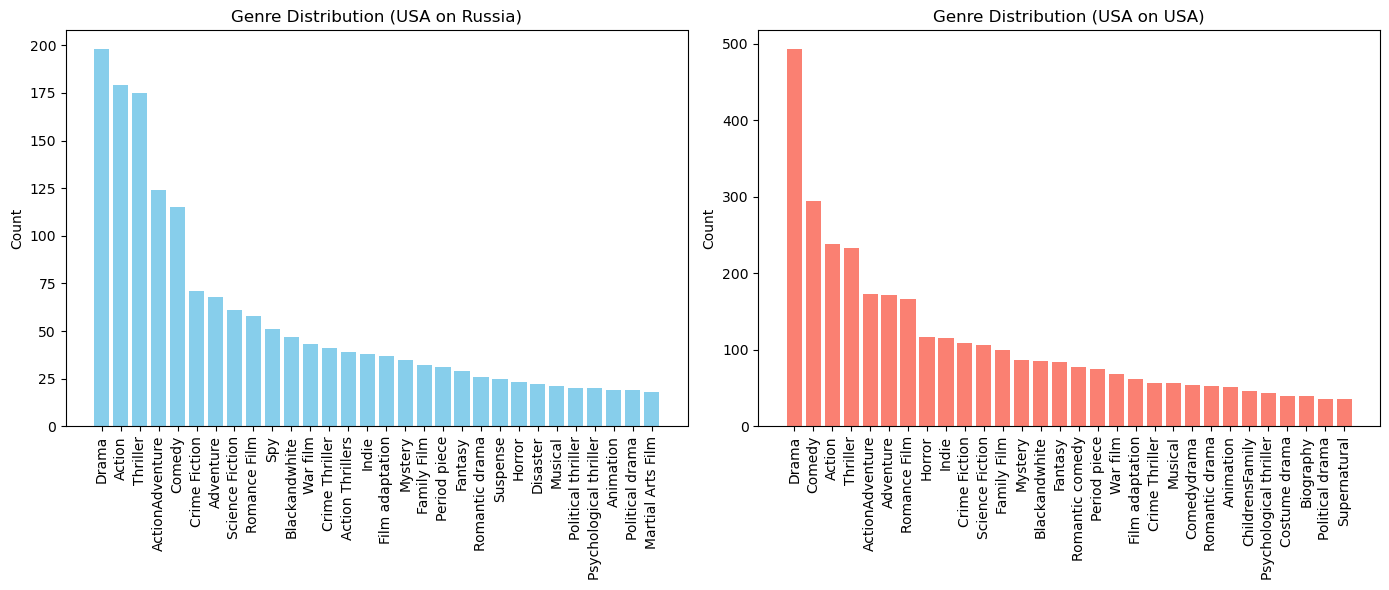

In [56]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for USA and Russia
axes[0].bar(genres_count_us_on_russia_reduced.keys(), genres_count_us_on_russia_reduced.values(), color='skyblue')
axes[0].set_title('Genre Distribution (USA on Russia)')
axes[0].set_xticklabels(genres_count_us_on_russia_reduced.keys(), rotation=90)
axes[0].set_ylabel('Count')

# Plot for Rest of the World
axes[1].bar(genres_count_us_on_us_reduced.keys(), genres_count_us_on_us_reduced.values(), color='salmon')
axes[1].set_title('Genre Distribution (USA on USA)')
axes[1].set_xticklabels(genres_count_us_on_us_reduced.keys(), rotation=90)
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [57]:
set(genres_count_us_on_russia_reduced.keys()) - set(genres_count_us_on_us_reduced.keys())

{'Action Thrillers',
 'Disaster',
 'Martial Arts Film',
 'Political thriller',
 'Spy',
 'Suspense'}

In [58]:
set(genres_count_us_on_us_reduced.keys()) - set(genres_count_us_on_russia_reduced.keys())

{'Biography',
 'ChildrensFamily',
 'Comedydrama',
 'Costume drama',
 'Romantic comedy',
 'Supernatural'}

We can see that, other than the first few common genres, there are some strong differences between the two subsets:
- Movies talking about Russia are often movies with tags such as 'Spy', 'Disaster' and 'Political Thriller', and often associated with a general feeling of suspence
- Biographical Movies are more common when talking about the USA, showing that production in the USA is more inclined to talking about people from the USA themselves
- There are much more movies talking about USA than Russia

## 3. Research Question 3

In this section, we delve deeper into our previous analysis by exploring how events have shaped the movie industry and whether public opinions about these movies vary across regions. We focus on a few events and countries for now, refining our scope in milestone 3 based on our colleagues' findings. To achieve this, we conduct sentiment analysis and named entity recognition to uncover perceptions of conflicts, particularly identifying who is portrayed as a hero or villain based on geographic context. 

In [4]:
df = pd.read_csv('data/movies_with_summaries.csv')
df.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
0,975900,tt0228333,Ghosts of Mars,Ghosts of Mars,2001-08-24,2001,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","['Action,Horror,Sci-Fi']",4.9,58872,14010832.0,98.0,['English Language'],['United States of America'],"Set in the second half of the 22nd century, th..."
1,261236,tt0083949,A Woman in Flames,Die flambierte Frau,1983,1983,['Drama'],['Drama'],5.9,648,NaN,106.0,['German Language'],['Germany'],"Eva, an upper class housewife, becomes frustra..."
2,171005,tt0097499,Henry V,Henry V,1989-11-08,1989,"['Costume drama', 'War film', 'Epic', 'Period ...","['Biography,Drama,History']",7.5,32088,10161099.0,137.0,['English Language'],['United Kingdom'],{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
3,77856,tt0058331,Mary Poppins,Mary Poppins,1964-08-27,1964,"['ChildrensFamily', 'Musical', 'Fantasy', 'Com...","['Comedy,Family,Fantasy']",7.8,189202,102272727.0,139.0,['English Language'],['United States of America'],The film opens with Mary Poppins perched in a...
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],['Drama'],7.7,24,NaN,108.0,['German Language'],['German Democratic Republic'],"Otto Brosowski, a communist miner, writes to t..."


In [5]:
# Download necessary NLTK packages for text processing and sentiment analysis
nltk.download('punkt')  # Tokenizer for splitting text into words
nltk.download('averaged_perceptron_tagger')  # POS tagger for grammatical structure
nltk.download('maxent_ne_chunker')  # NER chunker for extracting named entities
nltk.download('words')  # Word corpus for NER
nltk.download('stopwords')  # Common words to exclude from analysis
nltk.download('wordnet')  # Lexical database for English
nltk.download('vader_lexicon')  # Lexicon for sentiment analysis

# Define the set of English stopwords to remove common words that don't add meaning
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-

In [6]:
df = pd.read_csv('data/movies_with_summaries.csv')
wars_df = pd.read_csv('data/wars_filtered_clean.csv')
df.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
0,975900,tt0228333,Ghosts of Mars,Ghosts of Mars,2001-08-24,2001,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","['Action,Horror,Sci-Fi']",4.9,58872,14010832.0,98.0,['English Language'],['United States of America'],"Set in the second half of the 22nd century, th..."
1,261236,tt0083949,A Woman in Flames,Die flambierte Frau,1983,1983,['Drama'],['Drama'],5.9,648,NaN,106.0,['German Language'],['Germany'],"Eva, an upper class housewife, becomes frustra..."
2,171005,tt0097499,Henry V,Henry V,1989-11-08,1989,"['Costume drama', 'War film', 'Epic', 'Period ...","['Biography,Drama,History']",7.5,32088,10161099.0,137.0,['English Language'],['United Kingdom'],{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
3,77856,tt0058331,Mary Poppins,Mary Poppins,1964-08-27,1964,"['ChildrensFamily', 'Musical', 'Fantasy', 'Com...","['Comedy,Family,Fantasy']",7.8,189202,102272727.0,139.0,['English Language'],['United States of America'],The film opens with Mary Poppins perched in a...
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],['Drama'],7.7,24,NaN,108.0,['German Language'],['German Democratic Republic'],"Otto Brosowski, a communist miner, writes to t..."


In [7]:
wars_df.head()

,WarName,WarNum,StateName,Side,StartYear,EndYear,WhereFought,Outcome,BatDeath,Movies
0,Second Sino-Japanese,121,Japan,1,1931,1933,7,1,10000,931
1,Second Sino-Japanese,121,China,2,1931,1933,7,2,50000,931
2,Chaco,124,Bolivia,2,1932,1935,1,2,56661,1198
3,Chaco,124,Paraguay,1,1932,1935,1,1,36000,1198
4,Saudi-Yemeni,125,Saudi Arabia,1,1934,1934,6,1,100,806


### Extract wars belligerents

From the wars.csv dataset we extract the different contries involved in the conlicts as well as their side. The cold war case is a bit more complicated since... 

In [8]:
#WWII
wwii_bell = wars_df[wars_df['WarName']=='World War II'][['StateName', 'Side', 'Outcome']]
wwii_bell_side1 = wwii_bell[wwii_bell['Side'] == 1]['StateName'].values.tolist()
wwii_bell_side2 = wwii_bell[wwii_bell['Side'] == 2]['StateName'].values.tolist()
print(wwii_bell_side1)

#Cold War TODO
wwii_bell = wars_df[wars_df['WarName']=='World War II'][['StateName', 'Side', 'Outcome']]
wwii_bell_side1 = wwii_bell[wwii_bell['Side'] == 1]['StateName'].values.tolist()
wwii_bell_side2 = wwii_bell[wwii_bell['Side'] == 2]['StateName'].values.tolist()
print(wwii_bell_side1)

#Korean
korean_bell = wars_df[wars_df['WarName']=='Korean'][['StateName', 'Side', 'Outcome']]
korean_bell_side1 = korean_bell[korean_bell['Side'] == 1]['StateName'].values.tolist()
korean_bell_side2 = korean_bell[korean_bell['Side'] == 2]['StateName'].values.tolist()
print(korean_bell_side1)

#Vietnam War
viet_bell = wars_df[wars_df['WarName']=='Vietnam War, Phase 2'][['StateName', 'Side', 'Outcome']]
viet_bell_side1 = viet_bell[viet_bell['Side'] == 1]['StateName'].values.tolist()
viet_bell_side2 = viet_bell[viet_bell['Side'] == 2]['StateName'].values.tolist()
print(viet_bell_side1)



['Belgium', 'Yugoslavia', 'Norway', 'Canada', 'United States of America', 'United Kingdom', 'Netherlands', 'Romania', 'Bulgaria', 'Greece', 'Brazil', 'Italy', 'Australia', 'New Zealand', 'USSR', 'Poland', 'France', 'Mongolia', 'China', 'South Africa', 'Ethiopia']
['Belgium', 'Yugoslavia', 'Norway', 'Canada', 'United States of America', 'United Kingdom', 'Netherlands', 'Romania', 'Bulgaria', 'Greece', 'Brazil', 'Italy', 'Australia', 'New Zealand', 'USSR', 'Poland', 'France', 'Mongolia', 'China', 'South Africa', 'Ethiopia']
['Belgium', 'Canada', 'Colombia', 'United Kingdom', 'Netherlands', 'Greece', 'France', 'Turkey', 'Philippines', 'Thailand', 'Ethiopia', 'Australia', 'South Korea', 'United States of America']
['Vietnam']


### Separating per Event

We begin by focusing on three key conflicts: WWII, the Cold War, and the Vietnam War, as they are widely represented in films. War movies are our focus because they are likely to evoke divided opinions, given their portrayal of opposing sides. To achieve this, we filter the dataset to include only movies whose synopses contain keywords associated with these conflicts.

In [9]:
# Filter rows where 'Genres' contains "WarMovie"
df_war_movies = df[df['Genres'].str.contains("War film", case=False, na=False)].reset_index(drop=True)

# Defining the function that detects specific keywords related to conflicts 
def label_event_regex(summary):
    if re.search(r"(World\sWar\sII|WWII|Hitler|Nazis|Hiroshima|Holocaust)", summary, re.IGNORECASE):
        return "World War II"
    elif re.search(r"(Vietnam\sWar|Viet\sCong|Saigon)", summary, re.IGNORECASE):
        return "Vietnam War"
    elif re.search(r"(Cold\sWar|Soviet\sUnion|communism|nuclear)", summary, re.IGNORECASE):
        return "Cold War"
    elif re.search(r"(Kim|Korea|Korean|NKPA|Demilitarized\sZone|Pyongyang|Seoul|Joint\sChiefs\sof\sStaff)", summary, re.IGNORECASE):
        return "Korean"
    else:
        return "Other"

# Apply the function to the "summary" column 
df_war_movies['event'] = df_war_movies['summary'].apply(label_event_regex)

In [10]:
# Display movies labeled as "Cold War" for verification
df_war_movies[df_war_movies['event'] == "Cold War"].head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary,event
6,21209475,tt0024915,British Agent,British Agent,1934-09-15,1934,"['Romantic drama', 'War film', 'Drama', 'Spy']","['Drama,History,Romance']",6.1,796,NaN,80.0,['English Language'],['United States of America'],In the days leading up to the Russian Revoluti...,Cold War
41,28209320,tt1382250,The Heart of No Place,The Heart of No Place,2009-03-21,2009,"['Musical', 'Drama', 'War film']","['Drama,Music,War']",8.2,26,NaN,85.0,[],[],Rock widow Y. tries to come to terms with the ...,Cold War
43,19245641,tt1300563,The Age of Stupid,The Age of Stupid,2009-02-06,2009,"['Social problem film', 'History', 'Experiment...","['Documentary,History,News']",7.0,4739,NaN,89.0,"['French Language', 'English Language']",['United Kingdom'],The film begins in the year 2055 in a world ra...,Cold War
93,189776,tt0114787,Underground,Underground,1995-04-01,1995,"['World cinema', 'Drama', 'Comedy', 'War film'...","['Comedy,Drama,Fantasy']",8.0,61979,171082.0,170.0,"['French Language', 'SerboCroatian', 'German L...","['Serbia and Montenegro', 'Bulgaria', 'France'...",{{Plot|datePart One: War19411944Part Two: Cold...,Cold War
152,11347793,tt0808417,Persepolis,Persepolis,2007-06-27,2007,"['Biography', 'World cinema', 'Film adaptation...","['Animation,Biography,Drama']",8.0,101439,22752488.0,95.0,"['French Language', 'Persian Language', 'Germa...","['France', 'United States of America']",{{Copy edit-section}} The film begins at Paris...,Cold War


In [11]:
# Separate the movies into different events
wwii_movies = df_war_movies[(df_war_movies['event'] == "World War II")&(df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in (wwii_bell_side1 + wwii_bell_side2))))]
cold_war_movies = df_war_movies[df_war_movies['event'] == "Cold War"]
vietnam_war_movies = df_war_movies[df_war_movies['event'] == "Vietnam War"]
korean_war_movies = df_war_movies[df_war_movies['event'] == "Korean"]

# Randomly sample 100 WWII movies to manage computational load
test_sample=wwii_movies.sample(100)

### Sentiment Analysis
As an example, we conduct an overall sentiment analysis on the Word War II movies to highlight differences in their portrayal. Using the sentiment analyzer, we calculate sentiment scores (negative, neutral, positive, and compound) for the summaries of WWII movies.

In [12]:
# Extract the summaries from the sampled movies
synopses=test_sample["summary"].tolist()

In [13]:
# Preprocess the summaries: tokenize and clean the text and Remove stopwords
processed_docs = []
for synopsis in synopses:
    tokens = word_tokenize(synopsis.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_docs.append(filtered_tokens)

In [14]:
analyzer = SentimentIntensityAnalyzer()
sentiment_scores = []

# Analyze the sentiment of each processed summary
for tokens in processed_docs:
    text = ' '.join(tokens)
    score = analyzer.polarity_scores(text)
    sentiment_scores.append(score)

sentiment_df = pd.DataFrame(sentiment_scores)
test_sample = test_sample.reset_index(drop=True)
test_sample = pd.concat([test_sample, sentiment_df], axis=1)

# Display the summaries along with their sentiment scores
print(test_sample[['summary', 'neg', 'neu', 'pos', 'compound']])

                                              summary    neg    neu    pos  \
0   After World War II, Fred Derry , Homer Parrish...  0.163  0.672  0.165   
1   During the 1973 Yom Kippur War, an Israeli A-4...  0.221  0.693  0.086   
2   Taking place in the early 1980s and set in the...  0.229  0.638  0.133   
3   The film opens in 1991, with the funeral of a ...  0.141  0.569  0.291   
4   Pete Sandidge  is the reckless pilot of a B-25...  0.228  0.616  0.156   
..                                                ...    ...    ...    ...   
95  Starting in late May 1944, during the German r...  0.167  0.776  0.057   
96  Set during the German occupation of Paris duri...  0.192  0.808  0.000   
97  Mrs. Kay Miniver  and her family live a comfor...  0.174  0.687  0.140   
98  As a truckload of war survivors stops in front...  0.182  0.686  0.132   
99  {{review}} John Wayne stars as U.S. Navy Capta...  0.160  0.724  0.115   

    compound  
0     0.7630  
1    -0.9989  
2    -0.9895  
3  

#### displaying results

In [70]:
# Prepare data for visualization
sentiment_analysis_viz = test_sample[['Countries', 'neg', 'pos', 'neu']]
sentiment_analysis_viz['Countries'] = sentiment_analysis_viz['Countries'].apply(ast.literal_eval)

# Calculate the mean negative,neutral and positive sentiment score per country
neg_by_countries = pd.DataFrame(sentiment_analysis_viz.explode('Countries').groupby('Countries')['neg'].mean()).reset_index()
pos_by_countries = pd.DataFrame(sentiment_analysis_viz.explode('Countries').groupby('Countries')['pos'].mean()).reset_index()
neu_by_countries = pd.DataFrame(sentiment_analysis_viz.explode('Countries').groupby('Countries')['neu'].mean()).reset_index()

## Sentiment Scores per Country 
We decided to focus on Japan, the USA, and Germany, as these countries likely experienced the conflict in fundamentally different ways.

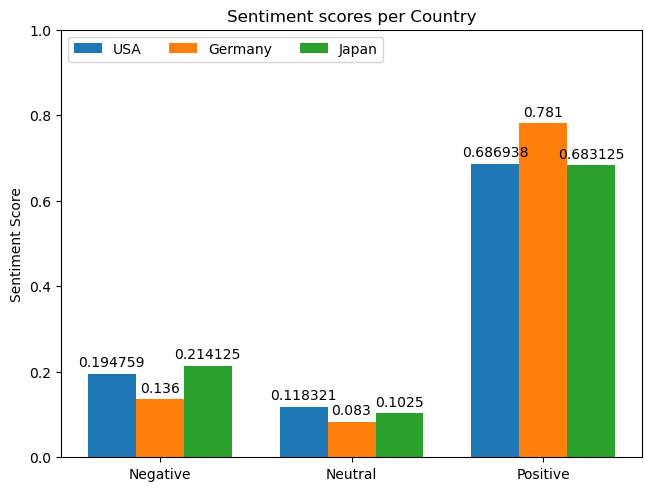

In [71]:
# Extract sentiment data for the USA, Japan and Germany
data_usa = [neg_by_countries.loc[neg_by_countries['Countries'] == 'United States of America']['neg'], pos_by_countries.loc[pos_by_countries['Countries'] == 'United States of America']['pos'], neu_by_countries.loc[neu_by_countries['Countries'] == 'United States of America']['neu']]
data_japan = [neg_by_countries.loc[neg_by_countries['Countries'] == 'Japan']['neg'], pos_by_countries.loc[pos_by_countries['Countries'] == 'Japan']['pos'], neu_by_countries.loc[neu_by_countries['Countries'] == 'Japan']['neu']]
data_germany = [neg_by_countries.loc[neg_by_countries['Countries'] == 'German Democratic Republic']['neg'], pos_by_countries.loc[pos_by_countries['Countries'] == 'German Democratic Republic']['pos'], neu_by_countries.loc[neu_by_countries['Countries'] == 'German Democratic Republic']['neu']]

# Organize the sentiment data into a dictionary for plotting
score = ("Negative", "Neutral", "Positive")
sentiment_means = {
    'USA': (data_usa[0].values.item(), data_usa[1].values.item(), data_usa[2].values.item()),
    'Germany': (data_germany[0].values.item(), data_germany[1].values.item(), data_germany[2].values.item()),
    'Japan': (data_japan[0].values.item(), data_japan[1].values.item(), data_japan[2].values.item()),
}

# Plot the sentiment scores for each country
x = np.arange(len(score))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in sentiment_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Sentiment Score')
ax.set_title('Sentiment scores per Country')
ax.set_xticks(x + width, score)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()

### 

### Named Entity recognition

We perform Named Entity Recognition (NER) to extract key roles in the synopses. This allows us to connect sentiment analysis results to the main figures or groups depicted in the films. Hence, we can better understand public opinion on these characters or figures and how they are portrayed in the context of major conflicts.


In [ ]:
##  Defining the function used in the anaylysis 

# Extracting entities corresponding to organizations from the NER tags
def extracting_entities(tree):
    # Initializing the entities 
    entities = []
    for subtree in tree.subtrees():
        # If the label of subtree corresponds to an organization, append its leaves (the names) to the entities list
        if (subtree.label() == 'ORGANIZATION'):
            entities.append(" ".join(word for word, tag in subtree.leaves()))
    return entities



# Defining a function to extract sentiment scores per entity
def entity_sentiment_analysis(summary, entities, country):
    # Initialization of the variables used 
    global average_sentiment
    entities_sentiment = []
    # Tokenizing the summary by sentences 
    sent = sent_tokenize(summary)
    
    for entity in entities:
        # Extracting the sentences that contain a specific entity, and obtaining the sentiment score of all of these sentences
        entity_sentences = [sentence for sentence in sent if entity in sentence]
        sentiment_scores = [analyzer.polarity_scores(sentence) for sentence in entity_sentences]

        if sentiment_scores:
            #Computing the average compound score for the entity, and creating 
            average_sentiment = {
                'Entity' : entity,
                'Country': country,
                'Compound' : sum([score['compound'] for score in sentiment_scores])/len(sentiment_scores),
            }
        entities_sentiment.append(average_sentiment)

    return entities_sentiment

In [16]:
# Tokenize the summaries for NER processing
wwii_movies['tokenized_summaries'] = wwii_movies['summary'].apply(word_tokenize)
cold_war_movies['tokenized_summaries'] = cold_war_movies['summary'].apply(word_tokenize)
korean_war_movies['tokenized_summaries'] = korean_war_movies['summary'].apply(word_tokenize)
vietnam_war_movies['tokenized_summaries'] = vietnam_war_movies['summary'].apply(word_tokenize)

In [17]:
# Initializing variables necessary for iteration over all of the conflicts
wars_iterator = [wwii_movies, cold_war_movies, korean_war_movies, vietnam_war_movies]
war_names = ['World War II', "Cold War", "Korean war", "Vietnan war"]

# Initializing stop words and Lemmatizer for data processing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [18]:
# Extracting the NER tags from each  summary

full_NER_TAGS = [[], [], [], []]
for i, test_sample in enumerate(wars_iterator):
    # Preprocess the text,tokenize, clean and remove stopwords
    tokens_summ = test_sample['tokenized_summaries'].to_list()
    NER_tags = []
    for summary in tokens_summ:
        filtered_token = [word for word in summary if word not in stop_words]
        lemmatized_tokens = ([lemmatizer.lemmatize(token) for token in filtered_token])
        pos_tags = nltk.pos_tag(lemmatized_tokens)
        # Perform NER chunking to identify named entities
        ner_tags = ne_chunk(pos_tags)
        NER_tags.append(ner_tags)

    full_NER_TAGS[i] = NER_tags
    

In [19]:
# Displaying one tag for verification 
full_NER_TAGS[1][0]

In [20]:
# Extracting entities 
full_entities = [[], [], [], []]
for i, tags in enumerate(full_NER_TAGS): 
    entities = []
    for tree in tags:
        entities.append(extracting_entities(tree))
    full_entities[i] = entities 

In [21]:
# Creating a new column in each movies dataset containing the entities
wwii_movies['Entities'] = full_entities[0]
cold_war_movies['Entities'] = full_entities[1]
korean_war_movies['Entities'] = full_entities[2]
vietnam_war_movies['Entities'] = full_entities[3]

# Verification
wwii_movies.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary,event,tokenized_summaries,Entities
2,5894429,tt0488380,Closing the Ring,Closing the Ring,2007-09-14,2007,"['Romantic drama', 'Romance Film', 'Drama', 'W...","['Drama,Romance']",6.4,4929,NaN,117.0,['English Language'],"['United States of America', 'Canada', 'United...","The film opens in 1991, with the funeral of a ...",World War II,"[The, film, opens, in, 1991, ,, with, the, fun...",[]
9,1533733,tt0032811,The Mortal Storm,The Mortal Storm,1940,1940,"['Drama', 'Political drama', 'Blackandwhite', ...",['Drama'],7.7,6243,NaN,100.0,['English Language'],['United States of America'],"In 1933, Freya Roth is a young German girl en...",World War II,"[In, 1933, ,, Freya, Roth, is, a, young, Germa...","[Nazi, Nazi]"
11,957179,tt0325123,Bright Young Things,Bright Young Things,2003-10-03,2003,"['Indie', 'Comedy of manners', 'Comedydrama', ...","['Comedy,Drama,War']",6.5,6454,NaN,104.0,['English Language'],['United Kingdom'],The primary characters are earnest aspiring no...,World War II,"[The, primary, characters, are, earnest, aspir...",[]
12,934809,tt0053143,Operation Petticoat,Operation Petticoat,1959,1959,"['ActionAdventure', 'Action', 'Comedy', 'War f...","['Comedy,Romance,War']",7.2,16281,NaN,124.0,['English Language'],['United States of America'],"United States Navy Rear Admiral Matt Sherman ,...",World War II,"[United, States, Navy, Rear, Admiral, Matt, Sh...","[States Navy Rear, ComSubPac, USS Sea, Command..."
16,5049873,tt0102426,Mediterraneo,Mediterraneo,1991-09-09,1991,"['Romantic comedy', 'World cinema', 'Drama', '...","['Comedy,Drama,War']",7.4,16709,NaN,96.0,"['Greek Language', 'Turkish Language', 'Italia...",['Italy'],"In 1941, one year after Italy joined Germany a...",World War II,"[In, 1941, ,, one, year, after, Italy, joined,...",[Isle]


### Entity-level sentiment analysis

In [22]:
# Perform entity-level sentiment analysis on every conflict's subset of movies
for i, test_sample in enumerate(wars_iterator):
    # Create a new dataframe for analysis
    summaries = test_sample[['summary', 'Entities', 'Countries']]

    # Perform the entity-level analysis on each row of the dataset and appending it in the results table
    results = []
    for _, row in summaries.iterrows():
        sentiments = entity_sentiment_analysis(row["summary"], row["Entities"], row['Countries'])
        results.extend(sentiments)

    # Convert results to a DataFrame
    entity_sentiments_df = pd.DataFrame(results)

    # TODO: maybe delete this ? 
    sentiment = []
    for j in range(len(entity_sentiments_df)):
        if entity_sentiments_df.iloc[j, 2] >= 0.05:
            sentiment.append('Protagonist')
        elif entity_sentiments_df.iloc[j, 2] <= -0.05:
            sentiment.append('Antagonist')
        else:
            sentiment.append('Protagonist')

    # Create a new column for the role of the entity (Protagonist or Antagonist) and drop the duplicates 
    entity_sentiments_df['Sentiment'] = sentiment
    entity_sentiments_df.drop_duplicates(inplace=True)
    entity_sentiments_df['Country'] = entity_sentiments_df['Country'].apply(literal_eval)

    # Explode the dataframe on the country column in order to analyse country-wise
    entity_sentiments_df_exploded = entity_sentiments_df.explode("Country").reset_index(drop=True)

    # Initializing the heatmap data by pivoting the dataframe on the "Country" column
    heatmap_data = entity_sentiments_df_exploded.pivot_table(index="Entity", columns="Country", values="Compound")

    ## Data Visualitation

    # Create the initial heatmap (first frame)
    frames = []
    first_side_data = entity_sentiments_df_exploded[entity_sentiments_df_exploded["Country"].isin(wwii_bell_side1)]
    frames.append(go.Frame(
            data=[go.Heatmap(
                z=first_side_data["Compound"],
                x=first_side_data["Country"],
                y=first_side_data["Entity"],
                colorscale="RdBu"
            )],
            name = 'Side 1'
        ))
    second_side_data = entity_sentiments_df_exploded[entity_sentiments_df_exploded["Country"].isin(wwii_bell_side2)]
    frames.append(go.Frame(
            data=[go.Heatmap(
                z=second_side_data["Compound"],
                x=second_side_data["Country"],
                y=second_side_data["Entity"],
                colorscale="RdBu"
            )],
            name = 'Side 2'
        ))

    heatmap = go.Heatmap(
        z=[first_side_data["Compound"]],
        x=first_side_data["Country"],
        y=first_side_data["Entity"],
        colorscale="RdBu",
        colorbar=dict(title="Sentiment Score")
    )

    # Create Figure
    fig = go.Figure(
        data=[heatmap],  # Initial data
        frames=frames    # Add all frames for animation
    )

    # Update Layout with Slider
    fig.update_layout(
        title=f"Sentiment Score Heatmap of {war_names[i]}",
        sliders=[{
            "steps": [
                {"args": [[frame.name]],
                "label": frame.name,
                "method": "animate"}
                for frame in frames
            ],
            "transition": {"duration": 500},
        }],

    )

    # Show Figure
    fig.show()


## 4. Research Question 4

How do global events, such as natural disasters, pandemics, wars, and economic downturns, influence public preferences for certain movie thematics?

### 4.0 Fetch and graph Google Search Trends: Example

In [ ]:
# Define the search query
query = "war movies"

In [ ]:
# Find interest for a given query over all time
df = gt.query_full_interest(query)
df.head(20)

Error fetching data: 401 Client Error: Unauthorized for url: https://realtime.oxylabs.io/v1/queries


TypeError: 'NoneType' object is not subscriptable

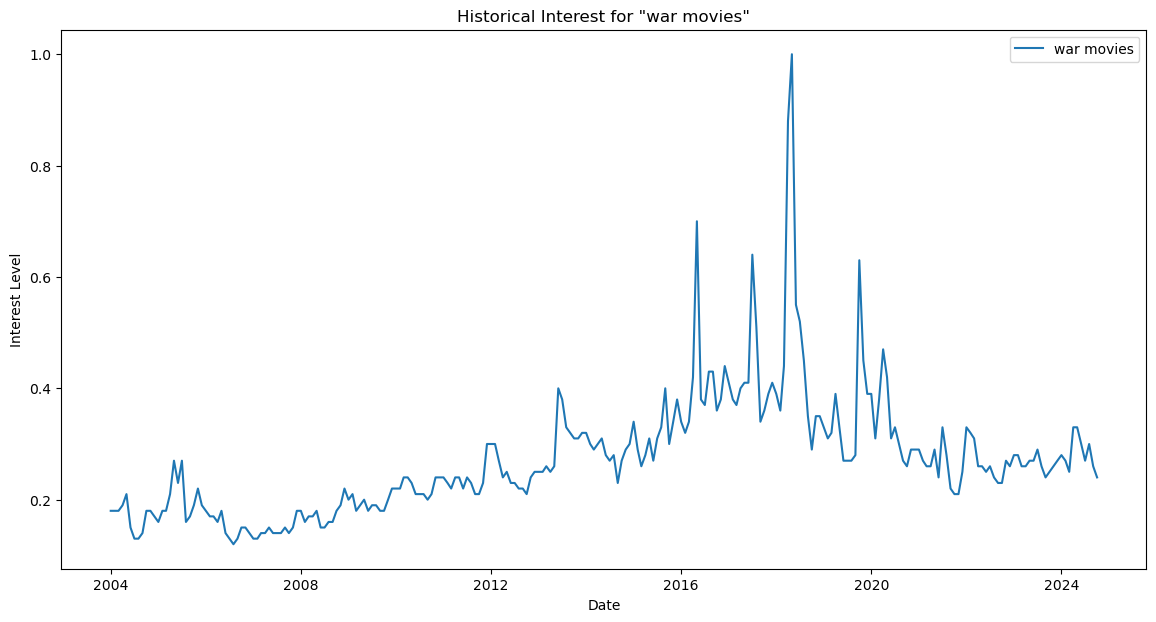

In [ ]:
# Plot the interest over time for a given query
gt.plot_interest_time_series(df, query)

In [ ]:
# Find interest for a given query around a specific date
df_partial = gt.query_interest_around_date(query, '2021-01-01')
df_partial.head(20)

,date,value,keyword
0,2020-12-27,0.89,war movies
1,2020-12-28,0.75,war movies
2,2020-12-29,0.76,war movies
3,2020-12-30,0.69,war movies
4,2020-12-31,0.72,war movies
5,2021-01-01,1.00,war movies
6,2021-01-02,0.95,war movies
7,2021-01-03,0.99,war movies
8,2021-01-04,0.66,war movies
9,2021-01-05,0.58,war movies


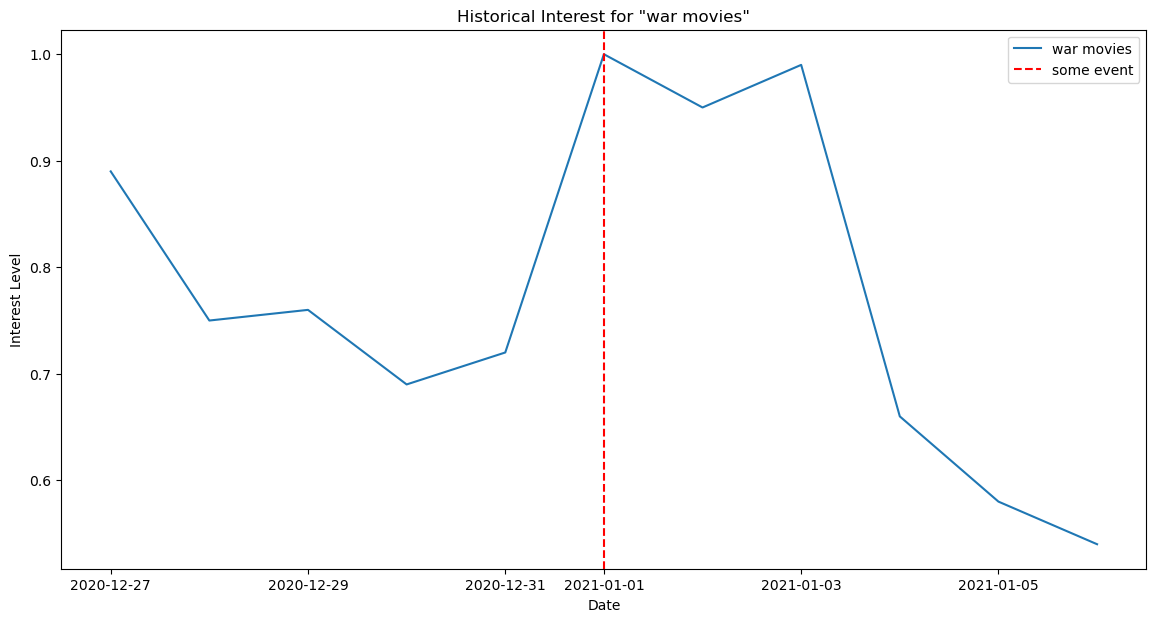

In [ ]:
# Plot the interest over time for a given query around a specific date
gt.plot_interest_time_series(df_partial, query, '2021-01-01', 'some event')

### 4.1 Wikidata Events timeline

In [ ]:
df_events = pd.read_csv('data/events.csv')
df_events['date'] = pd.to_datetime(df_events['date'])
df_events.head()

,date,description,event_type
0,1902-05-31,Second Boer War ends in British victory.,war
1,1903-06-11,King Alexander I of Serbia and his wife Queen ...,political instability
2,1904-02-08,A Japanese surprise attack on Port Arthur (Lus...,war
3,1905-01-22,The Revolution of 1905 in Russia erupts.,political instability
4,1905-03-31,"The First Moroccan Crisis begins, going until ...",catastrophe


In [ ]:
df_events['event_type'].value_counts()

event_type
catastrophe              203
war                      200
political instability     84
natural disaster          49
pandemics                  8
Name: count, dtype: int64

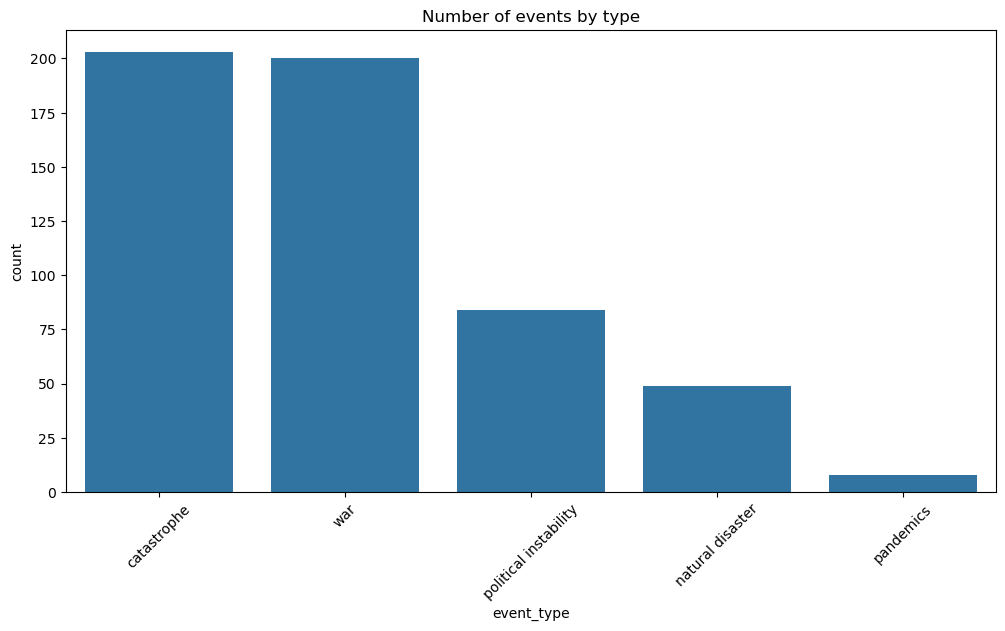

In [ ]:
# Graph the number of events by type
plt.figure(figsize=(12, 6))
sns.countplot(data=df_events, x='event_type', order=df_events['event_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Number of events by type')
plt.show()

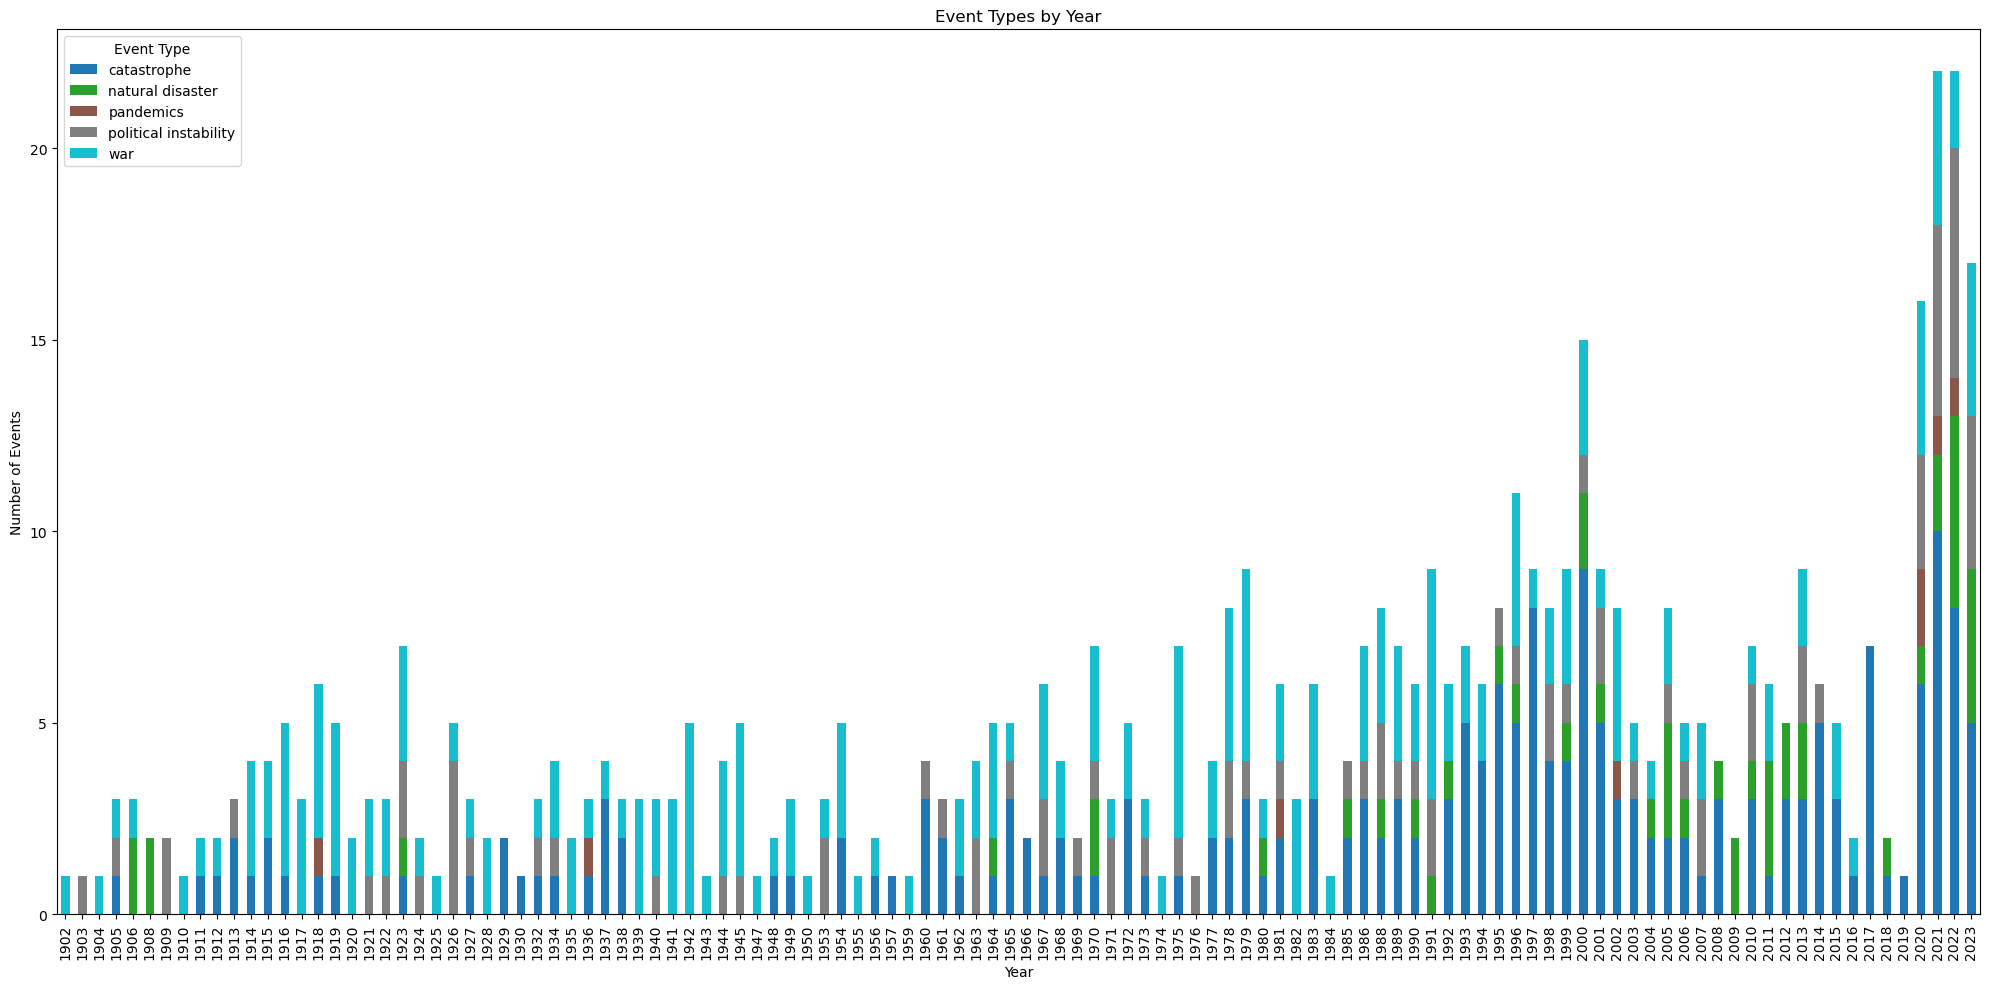

In [ ]:
# Plot the event types by year
df_year = df_events.copy()
df_year['year'] = df_year['date'].dt.year

# Group by year and event type, and count occurrences
df_grouped = df_year.groupby(['year', 'event_type']).size().reset_index(name='count')

# Pivot to get data in wide format for stacking
df_pivot = df_grouped.pivot(index='year', columns='event_type', values='count').fillna(0)

# Plot the stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(20, 10), cmap='tab10')

plt.title("Event Types by Year")
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.legend(title="Event Type")
plt.tight_layout()

### 4.2 Google Search Trends: Case Study

In [ ]:
# Sample some events marked as catastrophic
df_catastrophic = df_events[df_events['event_type'] == 'catastrophe']

pd.set_option('display.max_colwidth', None)
df_catastrophic.tail(30)

,date,description,event_type
466,2019-04-15,"A major fire engulfs Notre-Dame Cathedral in Paris, resulting in the roof and main spire collapsing.",catastrophe
468,2020-01-03,Qasem Soleimani is targeted and killed at Baghdad International Airport .,catastrophe
469,2020-01-08,"Ukraine International Airlines Flight 752 is shot down by Iranian Islamic Revolutionary Guards Corps (IRGC) shortly after taking off from Tehran, killing all 176 on board.",catastrophe
473,2020-08-04,"An explosion caused by unsafely stored ammonium nitrate kills at least 218 people, injures thousands, and severely damages the port of Beirut , Lebanon .",catastrophe
474,2020-09-16,"A United Nations Human Rights Council fact-finding mission formally accuses the Venezuelan government of crimes against humanity , including cases of killings, torture, violence against political opposition and disappearances since 2014.",catastrophe
478,2020-10-29,The International Organization for Migration (IOM) confirms the death of least 140 migrants who drowned off the coast of Senegal on a vessel bound for the Spanish Canary Islands .,catastrophe
482,2020-12-01,"The Arecibo Telescope of the Arecibo Observatory collapses, just weeks after the announcement of its planned demolition.",catastrophe
483,2021-01-06,"Supporters of President Donald Trump, gathered after a rally led by him, attack the United States Capitol , leading to five deaths.",catastrophe
485,2021-02-13,"Winter Storm Uri becomes the costliest winter storm in North American history, costing $200 billion and 237 lives, and triggering the 2021 Texas power crisis .",catastrophe
486,2021-02-22,"Luca Attanasio , the Italian ambassador to the Democratic Republic of the Congo , is murdered near Goma .",catastrophe


In [ ]:
# Select one event
event_date = "2020-01-08"
event_name = "Ukrainian Boeing 737 Crash"
keyword = "plane crash movies"

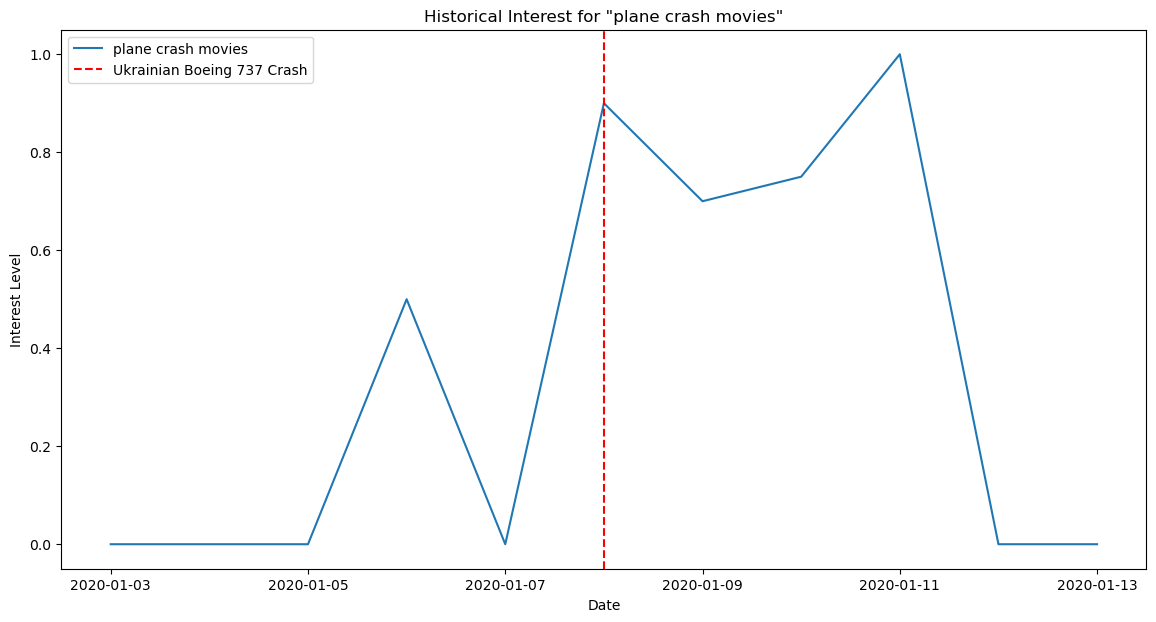

In [ ]:
# Query Google Trends for interest around the event date
df_event = gt.query_interest_around_date(keyword, event_date)

# Plot the interest over time
gt.plot_interest_time_series(df_event, keyword, event_date, event_name)

We can clearly observe an impact of interest for "plane crash movies" just after the worldwide news of a large plane crash. This can be applied to multiple events, either to see short-time trends or long-time evolution of trends.